In [1]:
import pandas as pd
import numpy as np

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import matplotlib as mat
import colordict as cd
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
import math

In [2]:
x = Data()
x.importpowders()

           Da       Dp  FWidth  FLength  ELength  EWidth      Volume  \
0      91.229  117.002  95.505  108.054   97.930  91.753  397553.759   
1      79.035  109.685  83.322   99.700   87.563  80.170  258496.560   
2      89.401  137.882  83.101  148.252  165.327  64.848  374138.469   
3      85.351   99.931  82.446  101.719   93.084  79.827  325549.588   
4      90.169  132.818  81.768  135.631  134.040  69.514  383853.784   
...       ...      ...     ...      ...      ...     ...         ...   
22088   3.663    4.912   3.014    6.118    5.179   2.556      25.744   
22089   3.208    4.221   3.010    5.078    4.035   2.716      17.291   
22090   3.160    4.280   3.008    4.673    3.531   2.923      16.520   
22091   3.801    4.480   3.003    5.737    5.341   2.714      28.747   
22092   3.309    4.191   3.002    4.940    3.898   2.871      18.963   

           Area  Perimeter  CHull  Area  ...  Curvature  Surface Area  \
0      6536.643    367.573     7648.185  ...        0.0     26

In [3]:
#TODO make these parameters of import powders (for ease)
data = x.data.copy() 
datalist = x.datalist.copy()
flow = x.flow.copy()
noflow = x.noflow.copy()
flowlist = x.flowpowders.copy()
noflowlist = x.noflowpowders.copy()

In [30]:
def modeltesthist(c, r, t):  # c = classify model, r = regression model, t = test set
    def pfix(arr):  # it works (flips axes or something)
        fppp = np.array(arr)
        fppp = np.absolute(fppp)
        fpp = fppp > 0
        newfp = fppp[fpp]
        return newfp

    rs = []  # r^2 values to return
    cps = c.predict(t.drop(columns=["Flow", "Flow Class"]))  # classify predictions
    rps = r.predict(t.drop(columns=["Flow", "Flow Class"]))  # regression predictions

    cps = pfix(cps)  # fixes cps and rps into 1d arrays of floats, instead of 2d arrays of floats
    rps = pfix(rps)

    cps = np.where(cps < .5, 0,
                   1)  # forces predictions into classification of 1 or 0 (flow or no flow) (to be revised later)

    fps = cps * rps  # final predictions (0 if no flow and regression prediction otherwise)

    exp = t["Flow"].to_numpy()  # expected values
    cexp = t["Flow Class"].to_numpy()  # classify expected values

    b = exp != 0
    rexp = exp[b]  # regression expected values

    cstats = (cps * cexp) * 2
    cstats = cstats + (cexp - cps)  # breaks results into one array of values 0, 1, -1, and 2 (specified below)
    cstats = np.where(cstats < 0, 3, cstats)

    csum = np.bincount(cstats.astype(int), minlength=4)
    tn = csum[0]  # true negative, red
    fn = csum[1]  # false negative, yellow
    fp = csum[3]  # false positive, orange
    tp = csum[2]  # true positive, green

    cp = tn + tp  # correct predictions
    tot = tn + fn + fp + tp

    print("Classify results:")
    print("\nNegative Predictions: ", (tn + fn) / tot * 100, "%\tActual Negative: ", (tn + fp) / tot * 100, "%")
    print("Positive Predicitons: ", (tp + fp) / tot * 100, "%\tActual Positive: ", (tp + fn) / tot * 100, "%")
    print("\nTrue Negatives: ", tn, "\t", tn / tot * 100, "%")
    print("False Negatives: ", fn, "  ", fn / tot * 100, "%")
    print("False Positives: ", fp, "\t", fp / tot * 100, "%")
    print("True Positives: ", tp, "\t", tp / tot * 100, "%")
    print("\nNo Flow Predicitons: ", (tn / (tn + fn)) * 100, "% Correct")
    print("Flow Predictions: ", (tp / (tp + fp)) * 100, "% Correct")
    print("\nCorrect Predictions:", cp, "  ", cp / tot * 100, "%")
    R = np.corrcoef(cps, cexp)[1, 0]
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")

    print("\n\nRegression Visualization and Statistics: ")

    colors = np.where(cstats == 0, "red", np.where(cstats == 1, "yellow", np.where(cstats == 3, "orange", "green")))
    rcb = colors != "orange"  # regression color boolean
    rcolors = colors[rcb]  # colors for flow powders only
    rcb = rcolors != "red"
    rcolors = rcolors[rcb]

    # scatter = plt.scatter(rps[b], rexp, c = rcolors, label = rcolors)

    cdict = {"yellow": "False Negative", "green": "True Positive", "red": "True Negative",
             "orange": "False Positive"}

    cax = np.empty(0)
    cay = np.empty(0)
    for g in ["yellow", "green", "orange", "red"]:
        ix = np.where(colors == g)
        plt.hist(rps[ix], color = g)
        cax = np.append(cax, rps[ix])
        cay = np.append(cay, exp[ix])
    R = np.corrcoef(cax, cay)[1, 0]
    plt.legend()
    plt.xlabel("Predicted Flow")
    plt.ylabel("Count")
    plt.title("Actual flow: " + str(exp[0]))
    plt.axvline(x=exp[0])
    plt.show()
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")
    
    cax = np.empty(0)
    cay = np.empty(0)
    
    plt.hist(rps)
    R = np.corrcoef(cax, cay)[1, 0]
    plt.legend()
    plt.xlabel("Predicted Flow")
    plt.ylabel("Count")
    plt.title("Actual flow: " + str(exp[0]))
    plt.axvline(x=exp[0])
    plt.show()
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")
    
    cax = np.empty(0)
    cay = np.empty(0)
    for g in ["yellow", "green"]:
        ix = np.where(colors == g)
        plt.scatter(rps[ix], exp[ix], c=colors[ix], label=cdict[g])
        cax = np.append(cax, rps[ix])
        cay = np.append(cay, exp[ix])
    R = np.corrcoef(cax, cay)[1, 0]
    plt.legend()
    plt.xlabel("Predicted Flow")
    plt.ylabel("Expected Flow")
    plt.title("Flow Powders Regression Prediction")
    plt.show()
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")

    cax = np.empty(0)
    cay = np.empty(0)
    for g in ["green", "orange"]:
        ix = np.where(colors == g)
        plt.scatter(fps[ix], exp[ix], c=colors[ix],
                    label=cdict[g])  # some of this can be made more efficient or modularized or something
        cax = np.append(cax, fps[ix])
        cay = np.append(cay, exp[ix])

    plt.xlabel("Predicted Flow")
    plt.ylabel("Expected Flow")
    plt.title("Predicted Flow Powder Regression Predictions vs Expected Flow")
    plt.legend()
    plt.show()
    R = np.corrcoef(cax, cay)[1, 0]
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")

    cax = np.empty(0)
    cay = np.empty(0)
    for g in ["green", "orange", "yellow", "red"]:
        ix = np.where(colors == g)
        plt.scatter(fps[ix], exp[ix], c=colors[ix], label=cdict[g])
        cax = np.append(cax, fps[ix])
        cay = np.append(cay, exp[ix])
    R = np.corrcoef(cax, cay)[1, 0]
    plt.xlabel("Predicted Flow")
    plt.ylabel("Expected Flow")
    plt.title("Final Prediction vs Final Expected")
    plt.legend()
    plt.show()
    R2 = R ** 2
    R = R * 100
    R2 = R2 * 100
    R = round(R, 4)
    R2 = round(R2, 4)
    rs.append(R2)
    print("R: ", R, "%  R^2: ", R2, "%")
    return cp / tot * 100

In [7]:
def tryhistmodel(c, r, t, visualize=True,
             ctd=[]):  # returns 1x4 array containing 4 R^2 values. Classification, Regression, Predicted Regression,
    # and Overall
    if len(ctd) != 0:
        c = c.drop(columns=ctd)
        r = r.drop(columns=ctd)
        t = t.drop(columns=ctd)
    cmodel = makemodel(c.drop(columns="Flow"), "Flow Class")
    rmodel = makemodel(r.drop(columns="Flow Class"))
    if visualize:
        return modeltesthist(cmodel, rmodel, t)

No handles with labels found to put in legend.


Classify results:

Negative Predictions:  67.96649275603318 %	Actual Negative:  68.79516653155682 %
Positive Predicitons:  32.033507243966824 %	Actual Positive:  31.204833468443187 %

True Negatives:  76807 	 53.21734671960201 %
False Negatives:  21287    14.74914603643116 %
False Positives:  22483 	 15.577819811954797 %
True Positives:  23750 	 16.455687432012027 %

No Flow Predicitons:  78.29938630293391 % Correct
Flow Predictions:  51.370233383081356 % Correct

Correct Predictions: 100557    69.67303415161405 %
R:  29.8794 %  R^2:  8.9278 %


Regression Visualization and Statistics: 


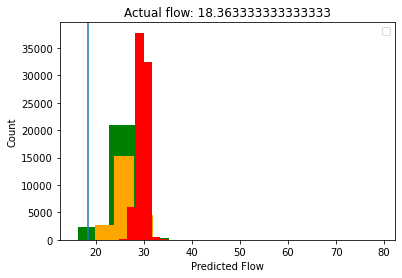

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  -24.1457 %  R^2:  5.8301 %


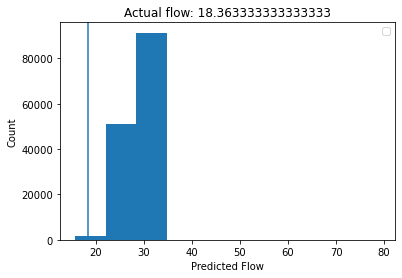

R:  nan %  R^2:  nan %


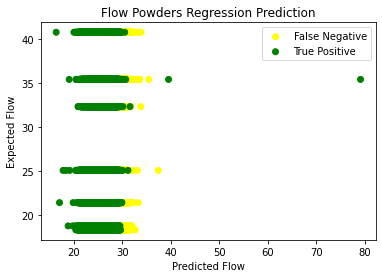

R:  21.6691 %  R^2:  4.6955 %


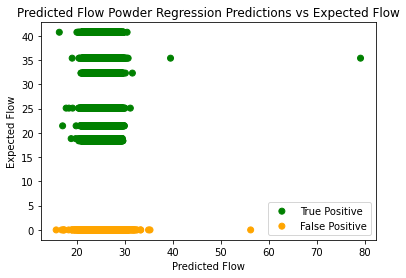

R:  -14.131 %  R^2:  1.9968 %


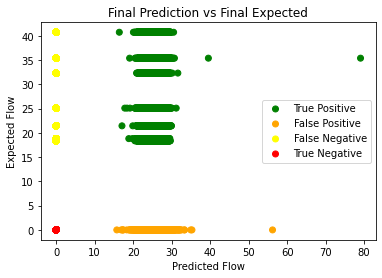

R:  23.8792 %  R^2:  5.7022 %


69.67303415161405

In [37]:
modeltesthist(cmodel, rmodel, data)

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  47.26558163287963 %	Actual Negative:  0.0 %
Positive Predicitons:  52.73441836712037 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  21287    47.26558163287963 %
False Positives:  0 	 0.0 %
True Positives:  23750 	 52.73441836712037 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 23750    52.73441836712037 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


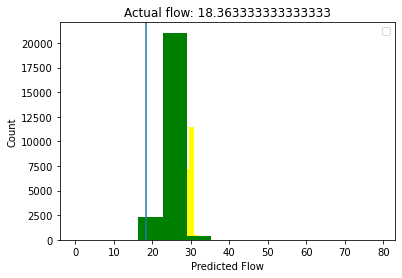

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  21.6691 %  R^2:  4.6955 %


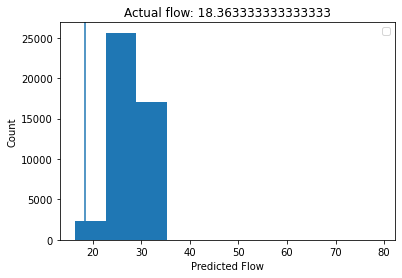

R:  nan %  R^2:  nan %


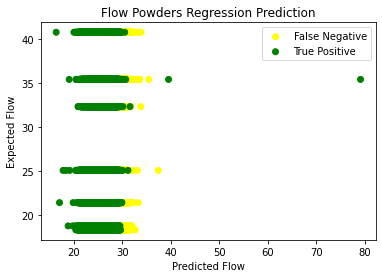

R:  21.6691 %  R^2:  4.6955 %


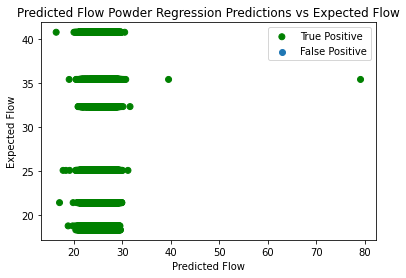

R:  14.4055 %  R^2:  2.0752 %


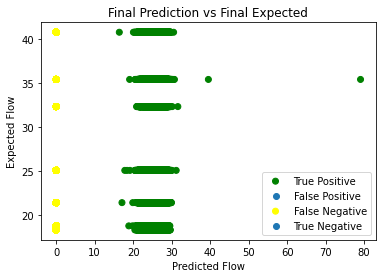

R:  -17.1275 %  R^2:  2.9335 %


52.73441836712037

In [41]:
modeltesthist(cmodel, rmodel, flow)

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  77.35622922751536 %	Actual Negative:  100.0 %
Positive Predicitons:  22.643770772484643 %	Actual Positive:  0.0 %

True Negatives:  76807 	 77.35622922751536 %
False Negatives:  0    0.0 %
False Positives:  22483 	 22.643770772484643 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 76807    77.35622922751536 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


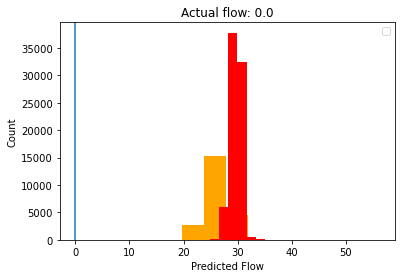

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


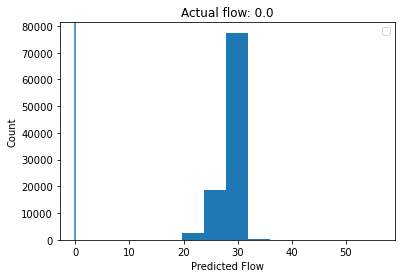

R:  nan %  R^2:  nan %


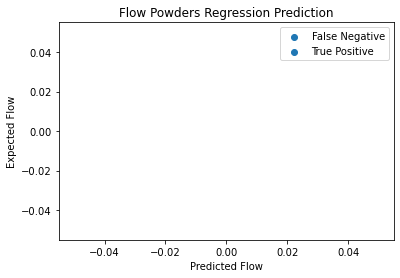

R:  nan %  R^2:  nan %


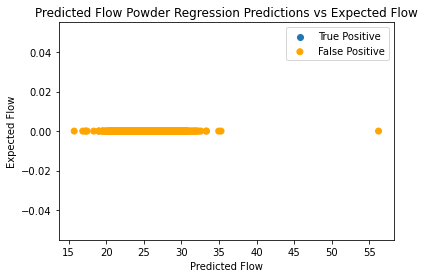

R:  nan %  R^2:  nan %


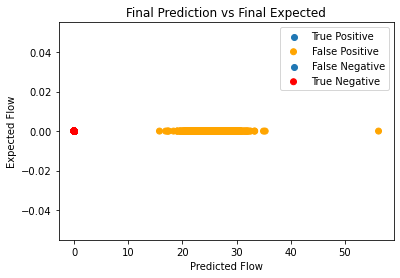

R:  nan %  R^2:  nan %


77.35622922751536

In [42]:
modeltesthist(cmodel, rmodel, noflow)

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  84.29001337494427 %	Actual Negative:  100.0 %
Positive Predicitons:  15.70998662505573 %	Actual Positive:  0.0 %

True Negatives:  15125 	 84.29001337494427 %
False Negatives:  0    0.0 %
False Positives:  2819 	 15.70998662505573 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 15125    84.29001337494427 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


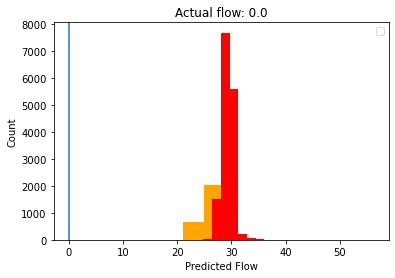

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


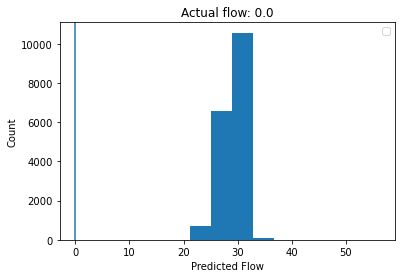

R:  nan %  R^2:  nan %


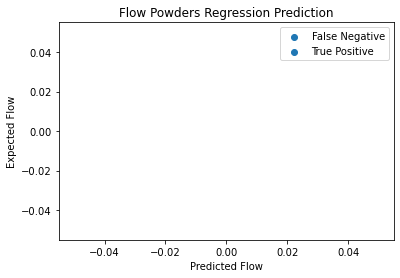

R:  nan %  R^2:  nan %


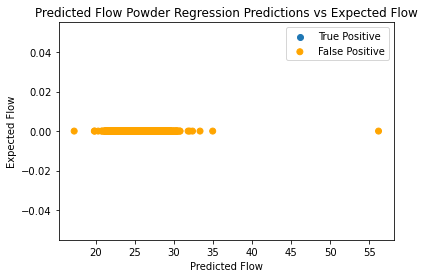

R:  nan %  R^2:  nan %


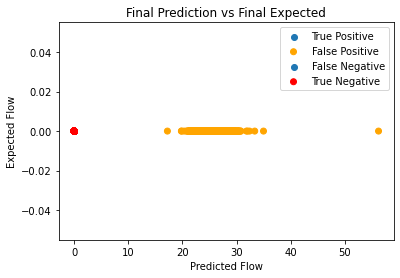

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  73.98107714701602 %	Actual Negative:  100.0 %
Positive Predicitons:  26.018922852983987 %	Actual Positive:  0.0 %

True Negatives:  4066 	 73.98107714701602 %
False Negatives:  0    0.0 %
False Positives:  1430 	 26.018922852983987 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 4066    73.98107714701602 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


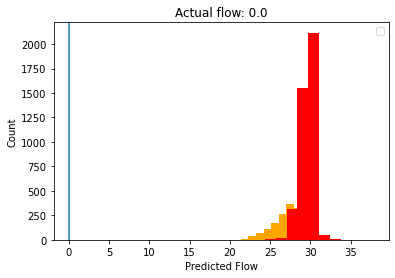

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


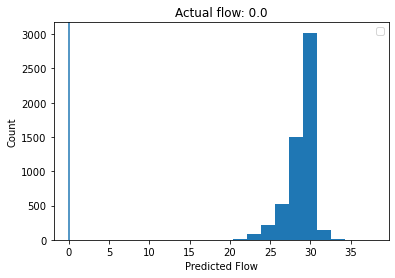

R:  nan %  R^2:  nan %


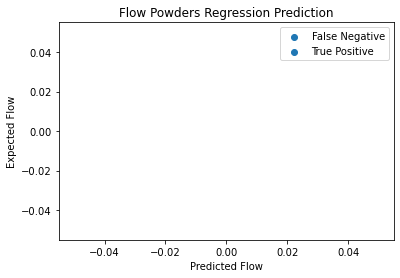

R:  nan %  R^2:  nan %


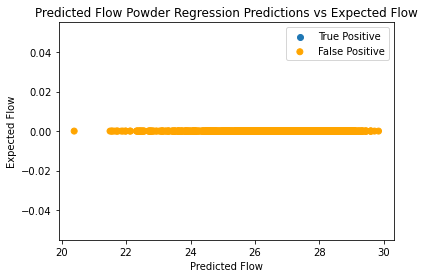

R:  nan %  R^2:  nan %


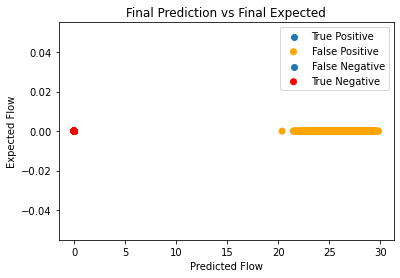

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  76.45375308963185 %	Actual Negative:  100.0 %
Positive Predicitons:  23.546246910368154 %	Actual Positive:  0.0 %

True Negatives:  11754 	 76.45375308963185 %
False Negatives:  0    0.0 %
False Positives:  3620 	 23.546246910368154 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 11754    76.45375308963185 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


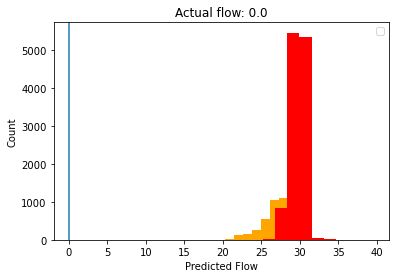

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


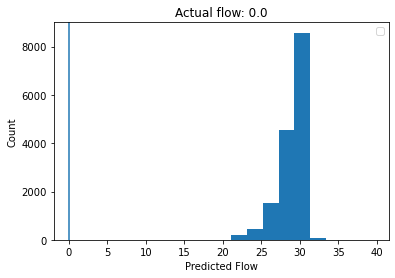

R:  nan %  R^2:  nan %


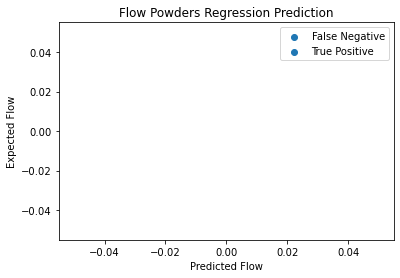

R:  nan %  R^2:  nan %


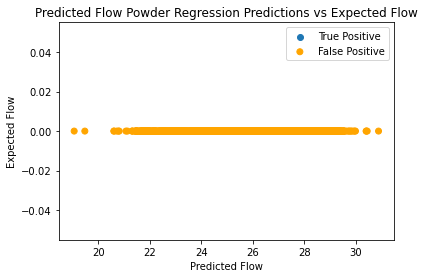

R:  nan %  R^2:  nan %


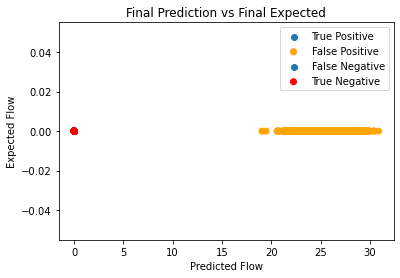

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  78.14489239163382 %	Actual Negative:  100.0 %
Positive Predicitons:  21.855107608366172 %	Actual Positive:  0.0 %

True Negatives:  5156 	 78.14489239163382 %
False Negatives:  0    0.0 %
False Positives:  1442 	 21.855107608366172 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 5156    78.14489239163382 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


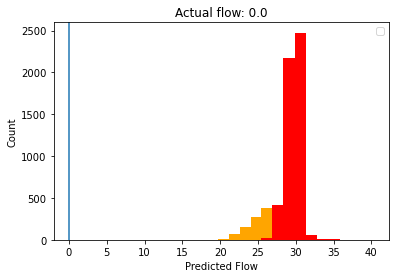

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


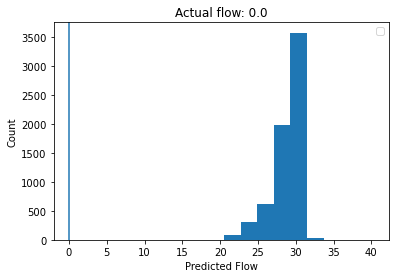

R:  nan %  R^2:  nan %


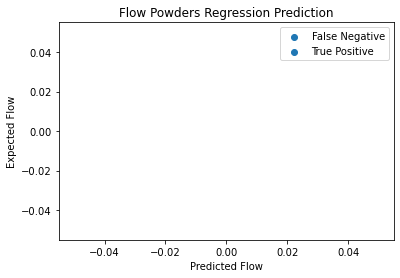

R:  nan %  R^2:  nan %


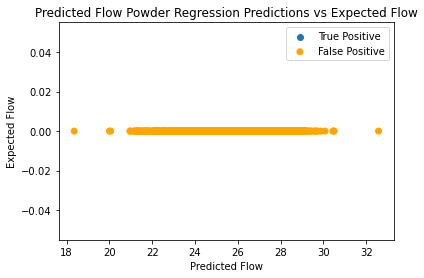

R:  nan %  R^2:  nan %


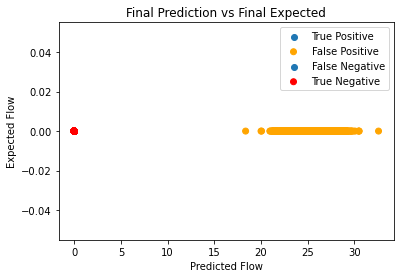

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  69.00344650582973 %	Actual Negative:  100.0 %
Positive Predicitons:  30.99655349417027 %	Actual Positive:  0.0 %

True Negatives:  9410 	 69.00344650582973 %
False Negatives:  0    0.0 %
False Positives:  4227 	 30.99655349417027 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 9410    69.00344650582973 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


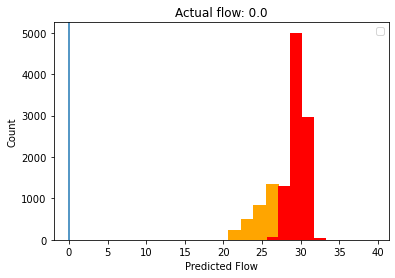

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


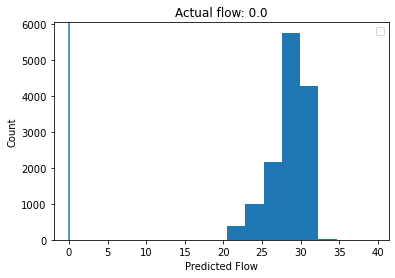

R:  nan %  R^2:  nan %


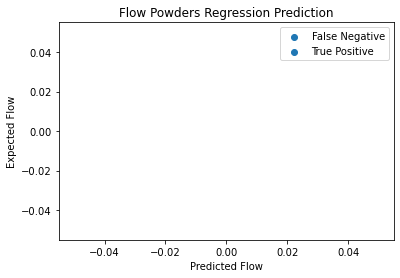

R:  nan %  R^2:  nan %


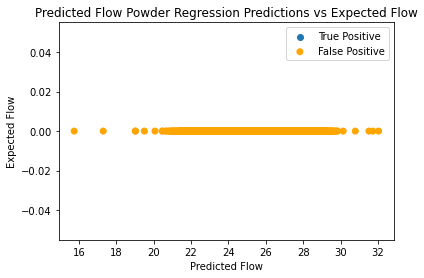

R:  nan %  R^2:  nan %


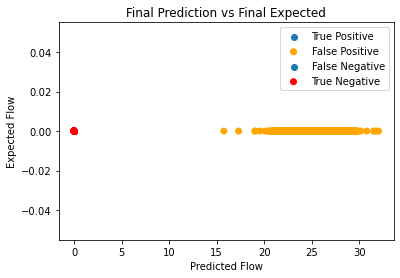

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  65.24701873935264 %	Actual Negative:  100.0 %
Positive Predicitons:  34.75298126064736 %	Actual Positive:  0.0 %

True Negatives:  4979 	 65.24701873935264 %
False Negatives:  0    0.0 %
False Positives:  2652 	 34.75298126064736 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 4979    65.24701873935264 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


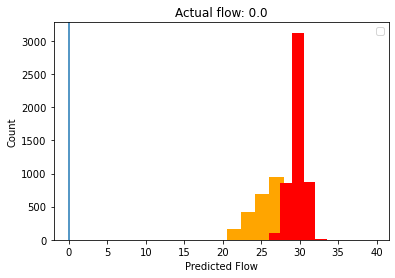

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


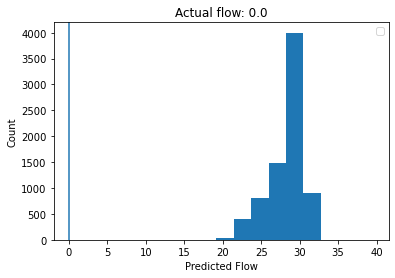

R:  nan %  R^2:  nan %


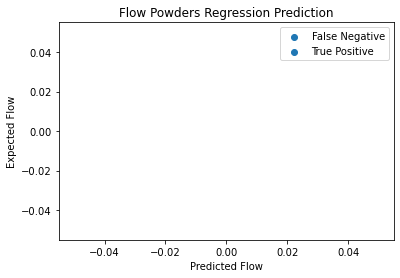

R:  nan %  R^2:  nan %


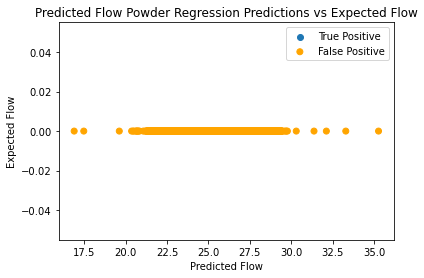

R:  nan %  R^2:  nan %


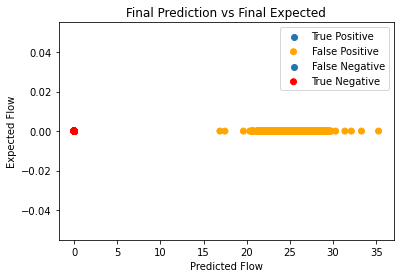

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  75.59189883046497 %	Actual Negative:  100.0 %
Positive Predicitons:  24.408101169535037 %	Actual Positive:  0.0 %

True Negatives:  7950 	 75.59189883046497 %
False Negatives:  0    0.0 %
False Positives:  2567 	 24.408101169535037 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 7950    75.59189883046497 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


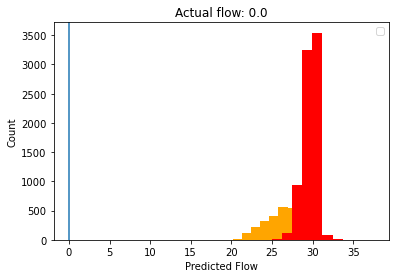

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


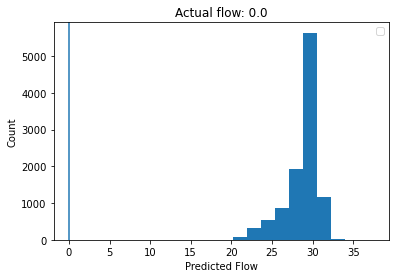

R:  nan %  R^2:  nan %


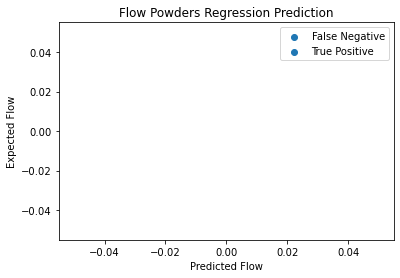

R:  nan %  R^2:  nan %


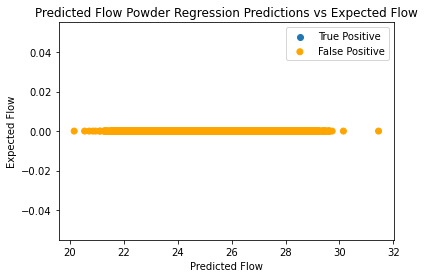

R:  nan %  R^2:  nan %


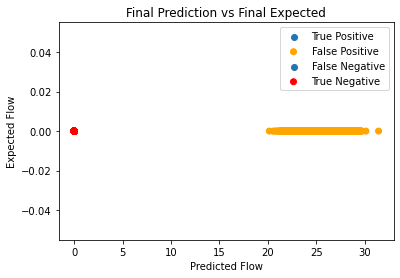

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  83.13492961571538 %	Actual Negative:  100.0 %
Positive Predicitons:  16.865070384284614 %	Actual Positive:  0.0 %

True Negatives:  18367 	 83.13492961571538 %
False Negatives:  0    0.0 %
False Positives:  3726 	 16.865070384284614 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 18367    83.13492961571538 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


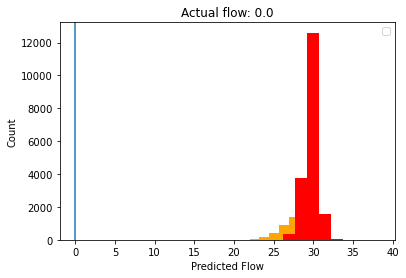

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


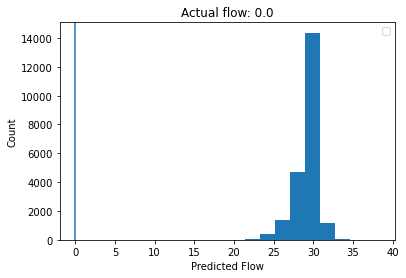

R:  nan %  R^2:  nan %


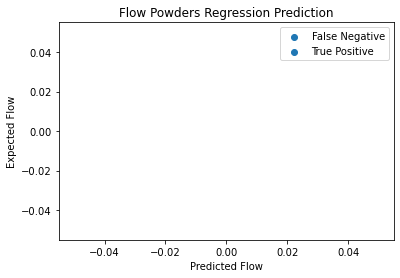

R:  nan %  R^2:  nan %


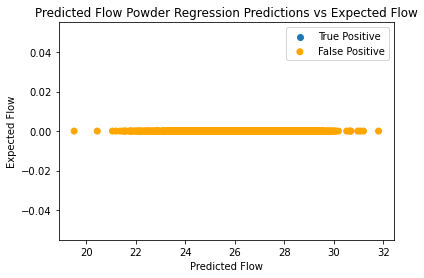

R:  nan %  R^2:  nan %


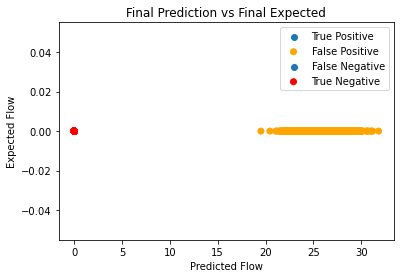

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  36.88484251968504 %	Actual Negative:  0.0 %
Positive Predicitons:  63.11515748031496 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1499    36.88484251968504 %
False Positives:  0 	 0.0 %
True Positives:  2565 	 63.11515748031496 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2565    63.11515748031496 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


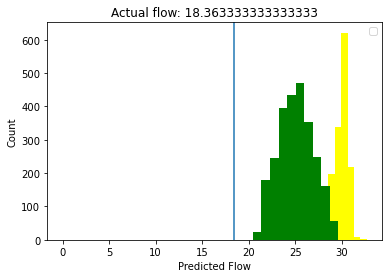

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  -0.0 %  R^2:  0.0 %


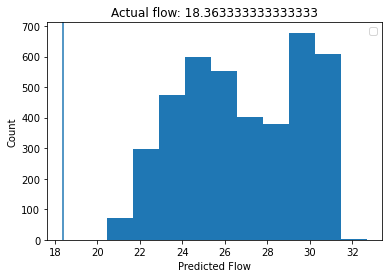

R:  nan %  R^2:  nan %


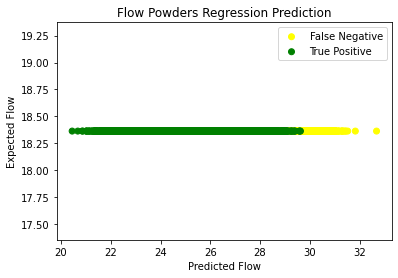

R:  -0.0 %  R^2:  0.0 %


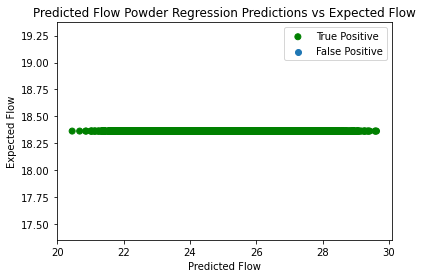

R:  0.0 %  R^2:  0.0 %


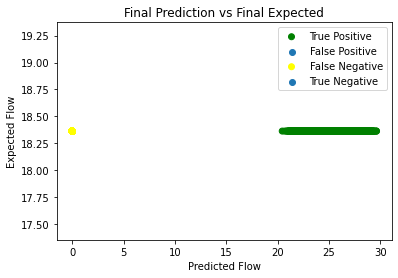

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  49.86775667227699 %	Actual Negative:  0.0 %
Positive Predicitons:  50.13224332772302 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  2074    49.86775667227699 %
False Positives:  0 	 0.0 %
True Positives:  2085 	 50.13224332772302 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2085    50.13224332772302 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


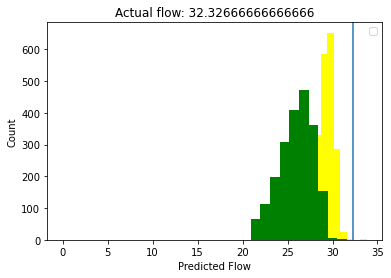

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


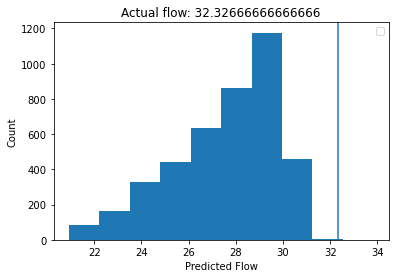

R:  nan %  R^2:  nan %


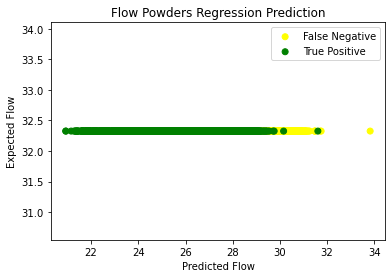

R:  nan %  R^2:  nan %


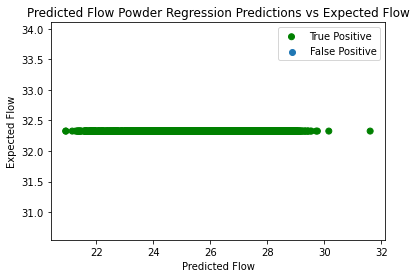

R:  0.0 %  R^2:  0.0 %


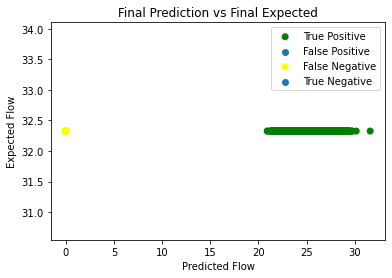

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  62.47549339955562 %	Actual Negative:  0.0 %
Positive Predicitons:  37.52450660044438 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  4780    62.47549339955562 %
False Positives:  0 	 0.0 %
True Positives:  2871 	 37.52450660044438 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2871    37.52450660044438 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


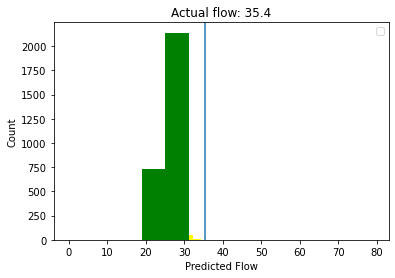

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


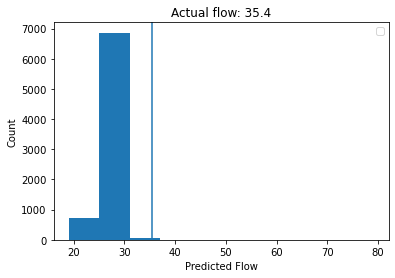

R:  nan %  R^2:  nan %


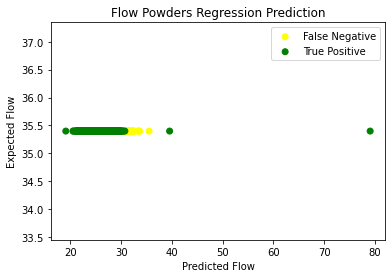

R:  nan %  R^2:  nan %


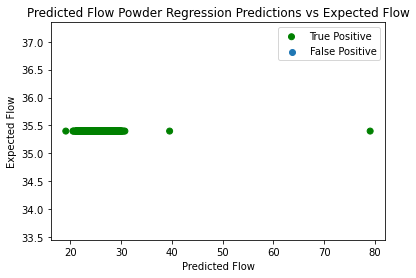

R:  0.0 %  R^2:  0.0 %


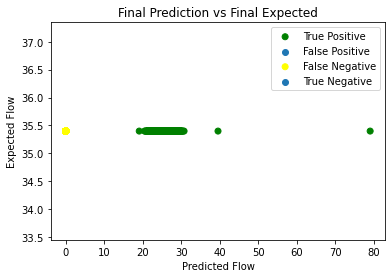

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  38.139591145518324 %	Actual Negative:  0.0 %
Positive Predicitons:  61.860408854481676 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  3153    38.139591145518324 %
False Positives:  0 	 0.0 %
True Positives:  5114 	 61.860408854481676 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 5114    61.860408854481676 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


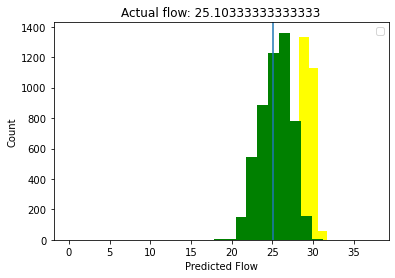

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  0.0 %  R^2:  0.0 %


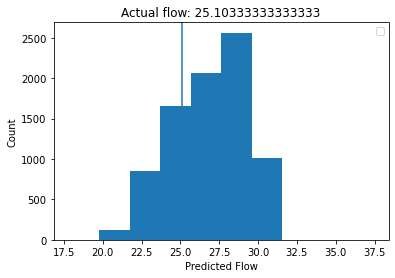

R:  nan %  R^2:  nan %


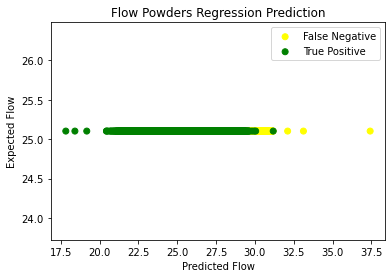

R:  0.0 %  R^2:  0.0 %


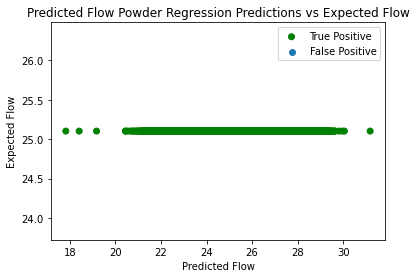

R:  0.0 %  R^2:  0.0 %


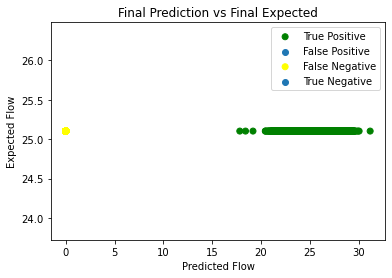

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  56.3582594000845 %	Actual Negative:  0.0 %
Positive Predicitons:  43.64174059991551 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  5336    56.3582594000845 %
False Positives:  0 	 0.0 %
True Positives:  4132 	 43.64174059991551 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 4132    43.64174059991551 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


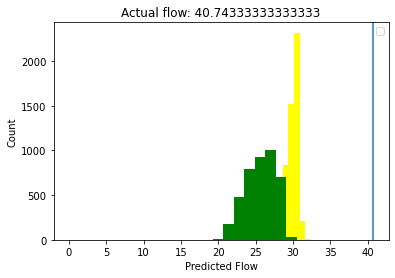

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  nan %  R^2:  nan %


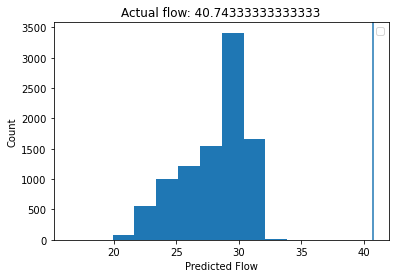

R:  nan %  R^2:  nan %


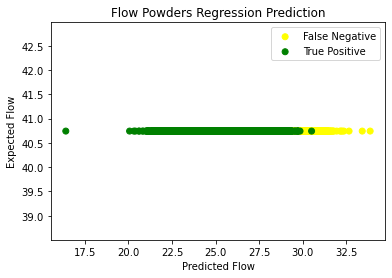

R:  nan %  R^2:  nan %


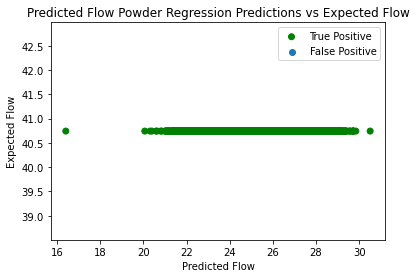

R:  0.0 %  R^2:  0.0 %


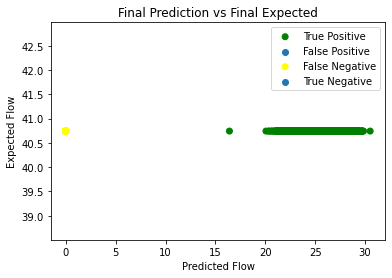

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  42.18495224784533 %	Actual Negative:  0.0 %
Positive Predicitons:  57.81504775215467 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  3622    42.18495224784533 %
False Positives:  0 	 0.0 %
True Positives:  4964 	 57.81504775215467 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 4964    57.81504775215467 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


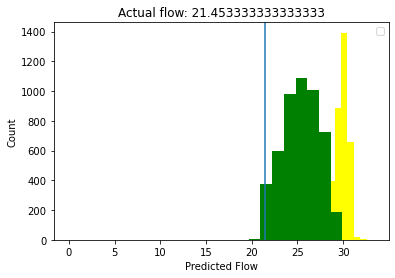

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  -0.0 %  R^2:  0.0 %


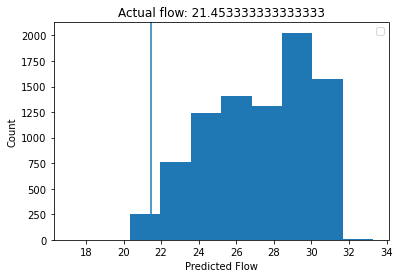

R:  nan %  R^2:  nan %


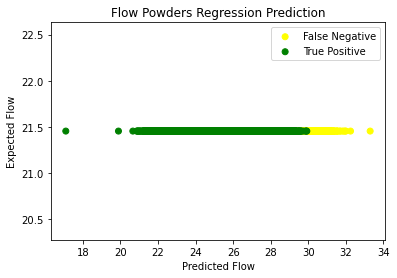

R:  -0.0 %  R^2:  0.0 %


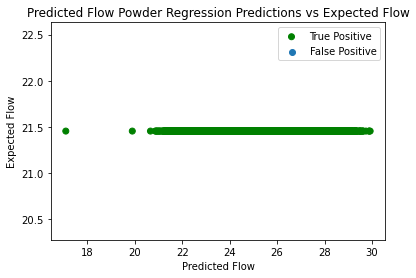

R:  0.0 %  R^2:  0.0 %


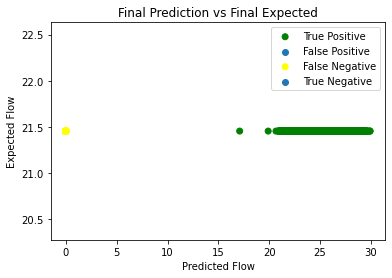

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  28.95847994370162 %	Actual Negative:  0.0 %
Positive Predicitons:  71.04152005629838 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  823    28.95847994370162 %
False Positives:  0 	 0.0 %
True Positives:  2019 	 71.04152005629838 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2019    71.04152005629838 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


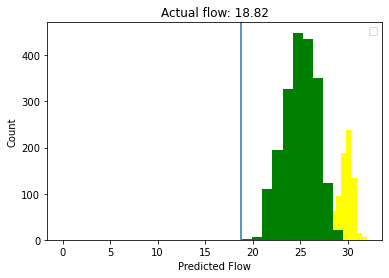

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No handles with labels found to put in legend.


R:  0.0 %  R^2:  0.0 %


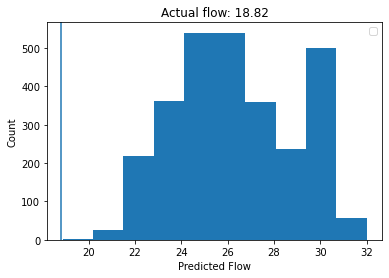

R:  nan %  R^2:  nan %


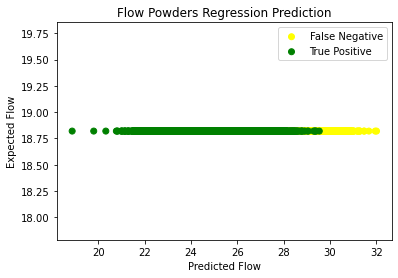

R:  0.0 %  R^2:  0.0 %


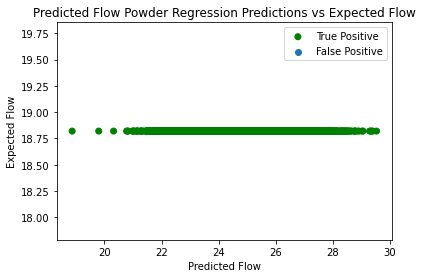

R:  0.0 %  R^2:  0.0 %


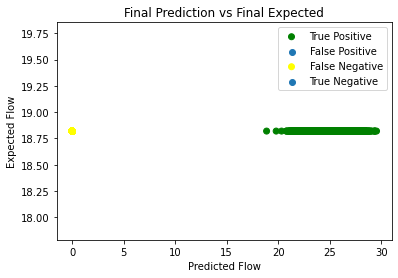

R:  -0.0 %  R^2:  0.0 %


[]

In [34]:
results = []
flowresults = []
noflowresults = []
#cmodel
#rmodel
plist = []
for i in datalist:
    plist.append(i.sample(n=2842))
df = pd.concat(plist)
df = df.sample(frac=1)
flowdf = df[df["Flow Class"] == 1]
#cmodel = makemodel(df.drop(columns="Flow"), "Flow Class")
#rmodel = makemodel(flowdf.drop(columns="Flow Class"))
for i in noflowlist:
    noflowresults.append(modeltesthist(cmodel, rmodel, i))
for i in flowlist:
    flowresults.append(modeltesthist(cmodel, rmodel, i))
results

In [35]:
flowresults

[63.11515748031496,
 50.13224332772302,
 37.52450660044438,
 61.860408854481676,
 43.64174059991551,
 57.81504775215467,
 71.04152005629838]

In [36]:
noflowresults

[84.29001337494427,
 73.98107714701602,
 76.45375308963185,
 78.14489239163382,
 69.00344650582973,
 65.24701873935264,
 75.59189883046497,
 83.13492961571538]

In [40]:
print(np.mean(flowresults))
print(np.mean(noflowresults))

55.01866066733323
75.73087871182358


1333/1333 [==============================] - 2s 2ms/step - loss: 21109.4121
Epoch 1/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2384
Epoch 2/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2249
Epoch 3/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2238
Epoch 4/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2221
Epoch 5/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2214
Epoch 6/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2197
Epoch 7/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2191
Epoch 8/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2190
Epoch 9/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2183
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 1568444.6250
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 402.2591
Epoch 

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  35.327234342012666 %	Actual Negative:  0.0 %
Positive Predicitons:  64.67276565798733 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1004    35.327234342012666 %
False Positives:  0 	 0.0 %
True Positives:  1838 	 64.67276565798733 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1838    64.67276565798733 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


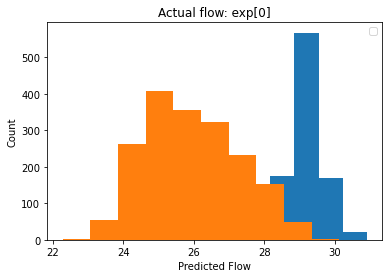

R:  nan %  R^2:  nan %


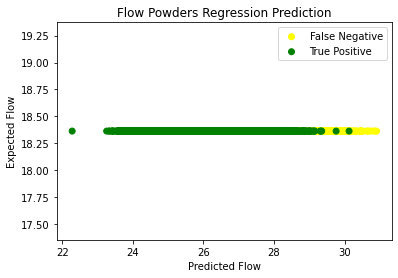

R:  nan %  R^2:  nan %


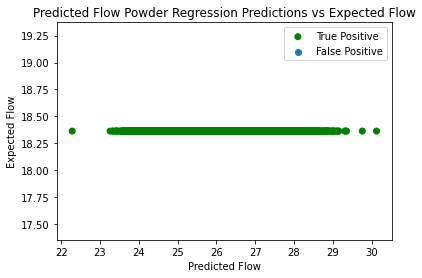

R:  0.0 %  R^2:  0.0 %


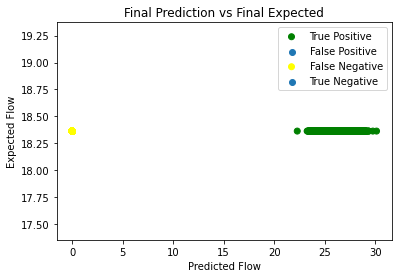

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  84.37719915552428 %	Actual Negative:  100.0 %
Positive Predicitons:  15.622800844475721 %	Actual Positive:  0.0 %

True Negatives:  2398 	 84.37719915552428 %
False Negatives:  0    0.0 %
False Positives:  444 	 15.622800844475721 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2398    84.37719915552428 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


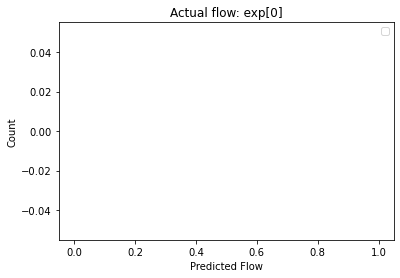

R:  nan %  R^2:  nan %


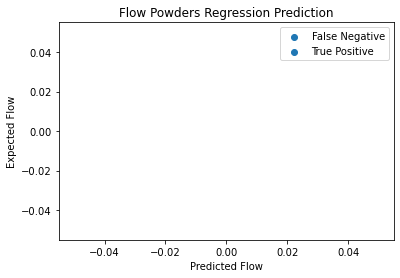

R:  nan %  R^2:  nan %


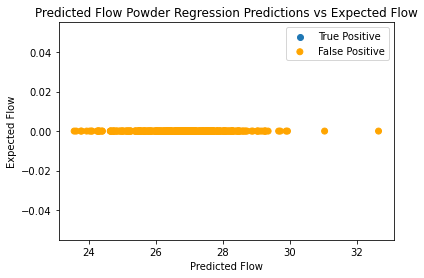

R:  nan %  R^2:  nan %


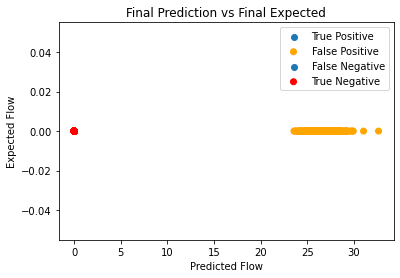

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  72.58972554539056 %	Actual Negative:  100.0 %
Positive Predicitons:  27.41027445460943 %	Actual Positive:  0.0 %

True Negatives:  2063 	 72.58972554539056 %
False Negatives:  0    0.0 %
False Positives:  779 	 27.41027445460943 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2063    72.58972554539056 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


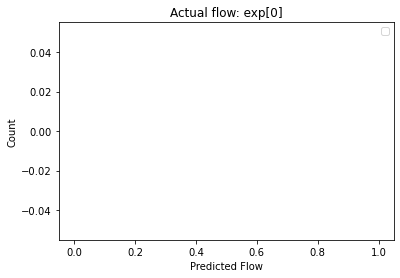

R:  nan %  R^2:  nan %


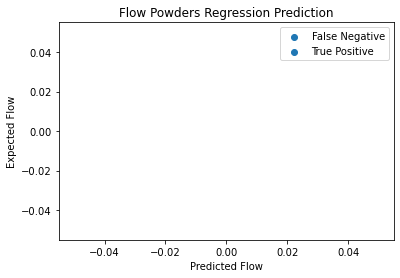

R:  nan %  R^2:  nan %


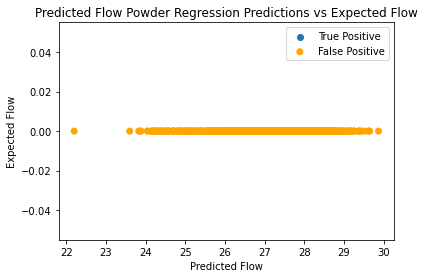

R:  nan %  R^2:  nan %


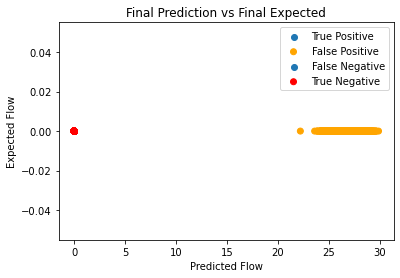

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  72.3082336382829 %	Actual Negative:  100.0 %
Positive Predicitons:  27.6917663617171 %	Actual Positive:  0.0 %

True Negatives:  2055 	 72.3082336382829 %
False Negatives:  0    0.0 %
False Positives:  787 	 27.6917663617171 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2055    72.3082336382829 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


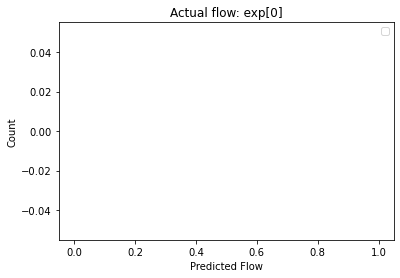

R:  nan %  R^2:  nan %


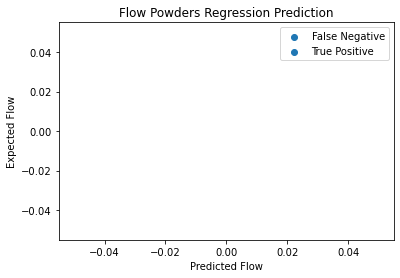

R:  nan %  R^2:  nan %


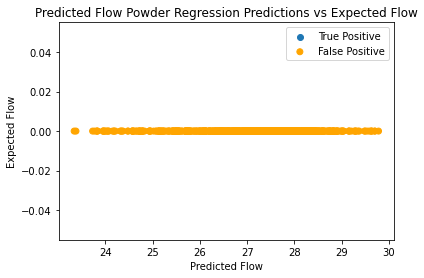

R:  nan %  R^2:  nan %


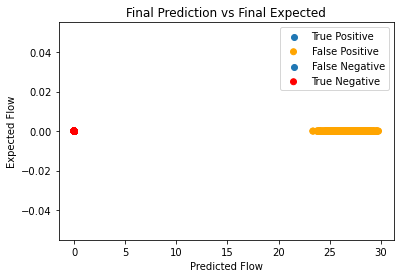

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  77.90288529204786 %	Actual Negative:  100.0 %
Positive Predicitons:  22.097114707952144 %	Actual Positive:  0.0 %

True Negatives:  2214 	 77.90288529204786 %
False Negatives:  0    0.0 %
False Positives:  628 	 22.097114707952144 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2214    77.90288529204786 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


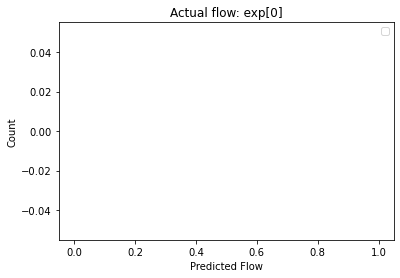

R:  nan %  R^2:  nan %


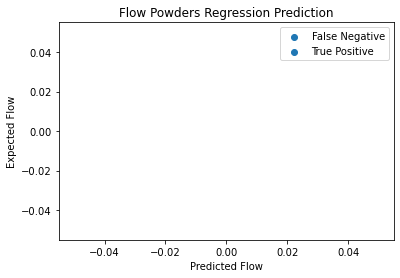

R:  nan %  R^2:  nan %


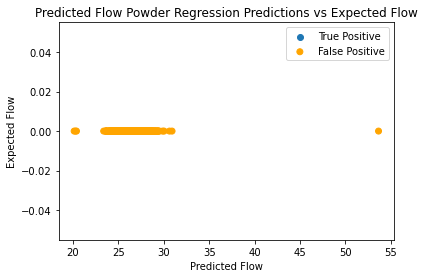

R:  nan %  R^2:  nan %


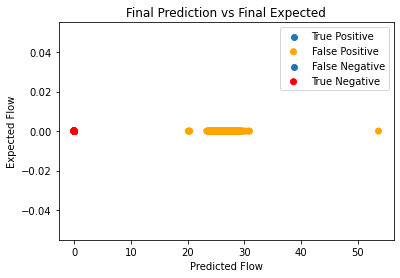

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  65.9042927515834 %	Actual Negative:  100.0 %
Positive Predicitons:  34.09570724841661 %	Actual Positive:  0.0 %

True Negatives:  1873 	 65.9042927515834 %
False Negatives:  0    0.0 %
False Positives:  969 	 34.09570724841661 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1873    65.9042927515834 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


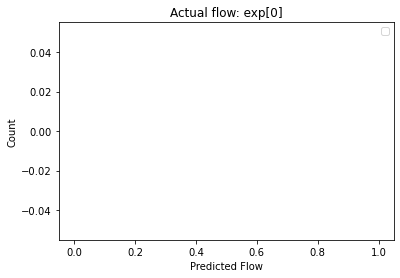

R:  nan %  R^2:  nan %


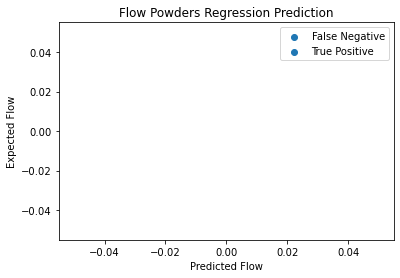

R:  nan %  R^2:  nan %


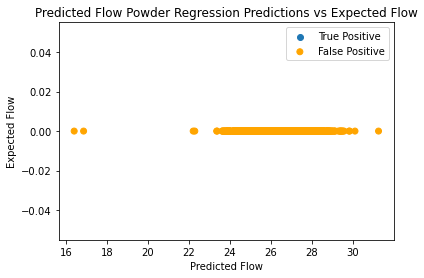

R:  nan %  R^2:  nan %


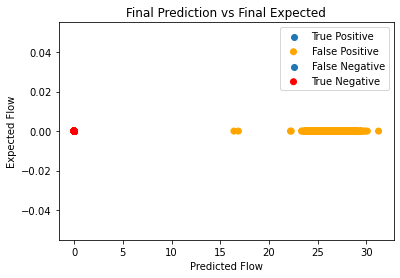

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  45.77762139338494 %	Actual Negative:  0.0 %
Positive Predicitons:  54.22237860661506 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1301    45.77762139338494 %
False Positives:  0 	 0.0 %
True Positives:  1541 	 54.22237860661506 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1541    54.22237860661506 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


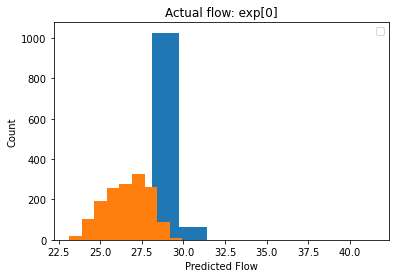

R:  nan %  R^2:  nan %


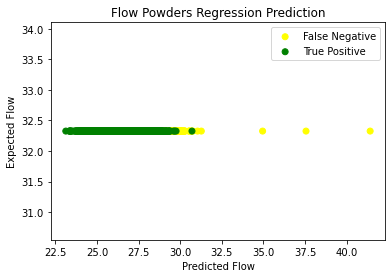

R:  nan %  R^2:  nan %


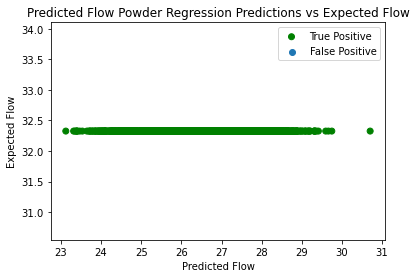

R:  nan %  R^2:  nan %


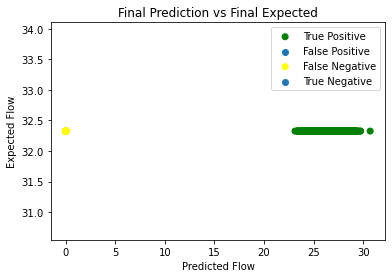

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  61.57635467980296 %	Actual Negative:  100.0 %
Positive Predicitons:  38.42364532019704 %	Actual Positive:  0.0 %

True Negatives:  1750 	 61.57635467980296 %
False Negatives:  0    0.0 %
False Positives:  1092 	 38.42364532019704 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1750    61.57635467980296 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


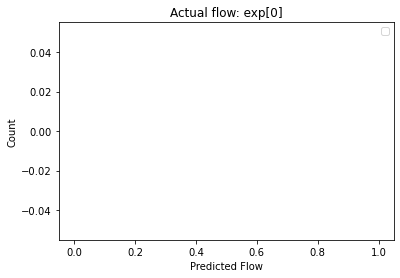

R:  nan %  R^2:  nan %


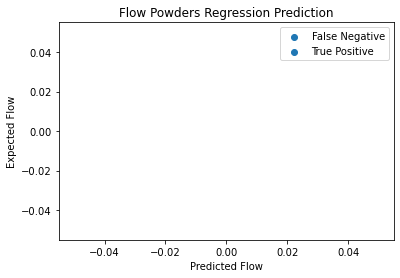

R:  nan %  R^2:  nan %


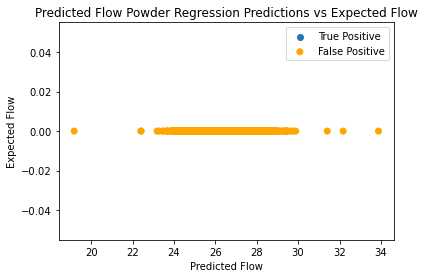

R:  nan %  R^2:  nan %


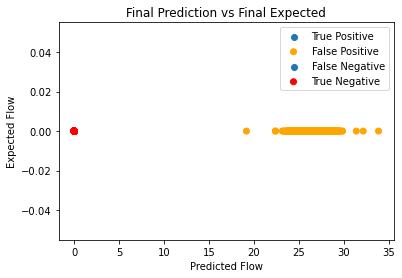

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  58.620689655172406 %	Actual Negative:  0.0 %
Positive Predicitons:  41.37931034482759 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1666    58.620689655172406 %
False Positives:  0 	 0.0 %
True Positives:  1176 	 41.37931034482759 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1176    41.37931034482759 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


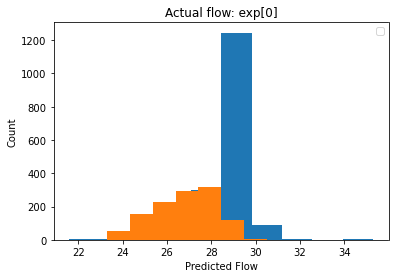

R:  nan %  R^2:  nan %


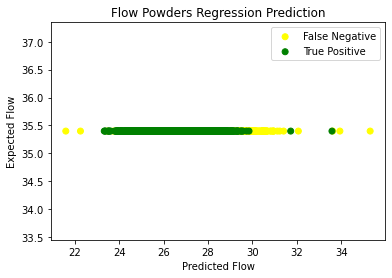

R:  nan %  R^2:  nan %


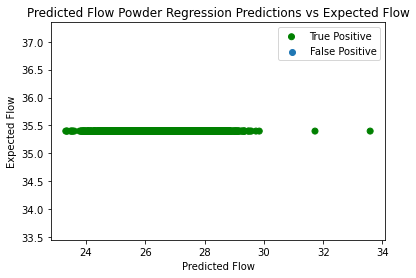

R:  nan %  R^2:  nan %


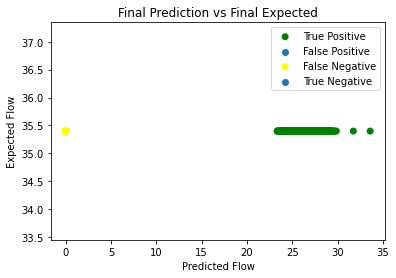

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  35.01055594651653 %	Actual Negative:  0.0 %
Positive Predicitons:  64.98944405348345 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  995    35.01055594651653 %
False Positives:  0 	 0.0 %
True Positives:  1847 	 64.98944405348345 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1847    64.98944405348345 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


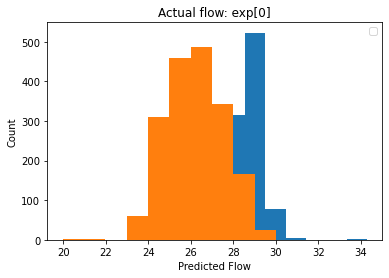

R:  0.0 %  R^2:  0.0 %


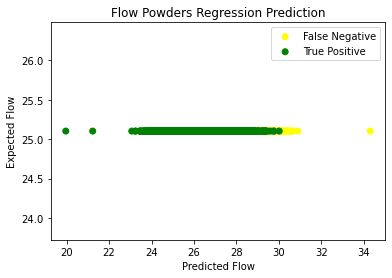

R:  0.0 %  R^2:  0.0 %


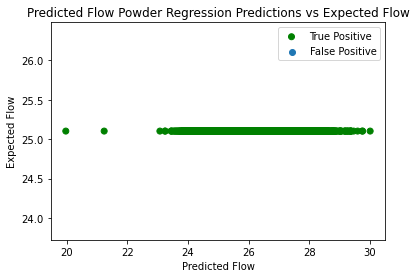

R:  nan %  R^2:  nan %


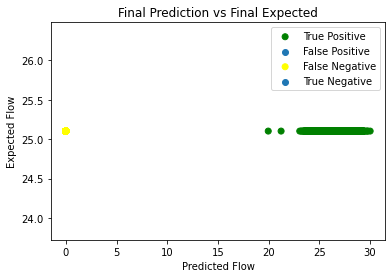

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  76.17874736101336 %	Actual Negative:  100.0 %
Positive Predicitons:  23.82125263898663 %	Actual Positive:  0.0 %

True Negatives:  2165 	 76.17874736101336 %
False Negatives:  0    0.0 %
False Positives:  677 	 23.82125263898663 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2165    76.17874736101336 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


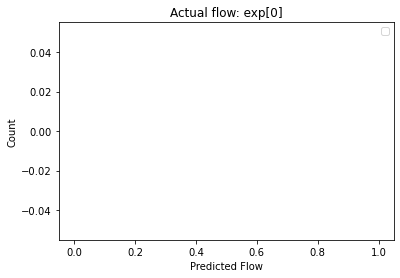

R:  nan %  R^2:  nan %


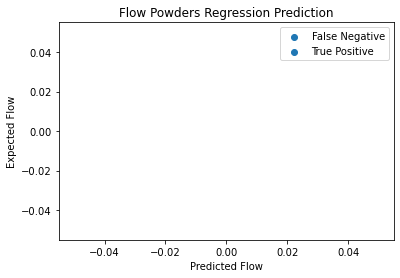

R:  nan %  R^2:  nan %


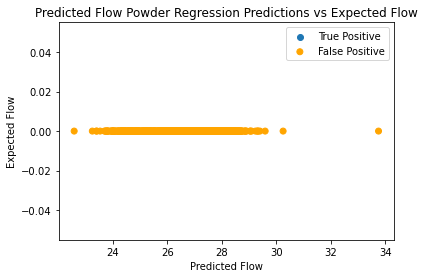

R:  nan %  R^2:  nan %


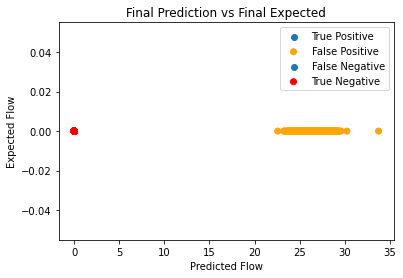

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  54.82054890921886 %	Actual Negative:  0.0 %
Positive Predicitons:  45.17945109078114 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1558    54.82054890921886 %
False Positives:  0 	 0.0 %
True Positives:  1284 	 45.17945109078114 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1284    45.17945109078114 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


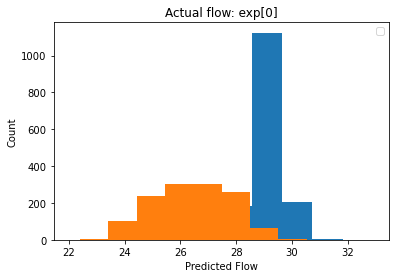

R:  nan %  R^2:  nan %


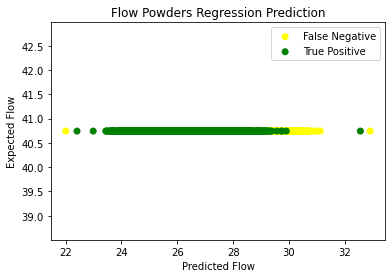

R:  nan %  R^2:  nan %


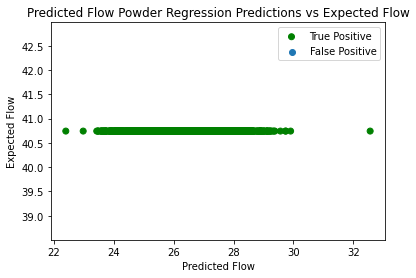

R:  nan %  R^2:  nan %


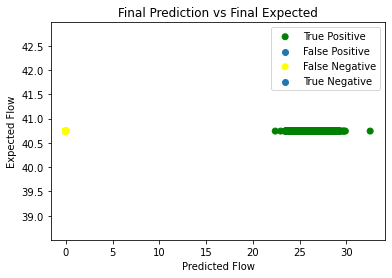

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  38.88106966924701 %	Actual Negative:  0.0 %
Positive Predicitons:  61.118930330752995 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1105    38.88106966924701 %
False Positives:  0 	 0.0 %
True Positives:  1737 	 61.118930330752995 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1737    61.118930330752995 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


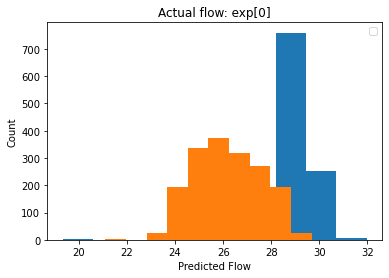

R:  0.0 %  R^2:  0.0 %


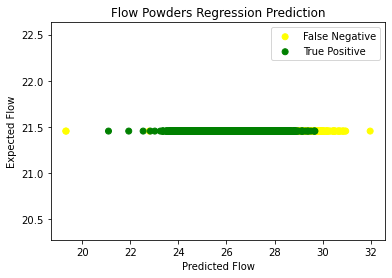

R:  0.0 %  R^2:  0.0 %


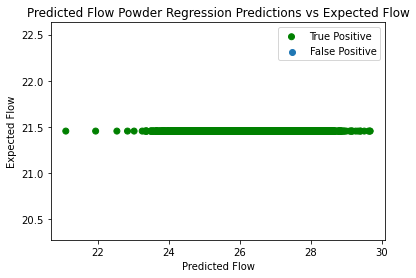

R:  0.0 %  R^2:  0.0 %


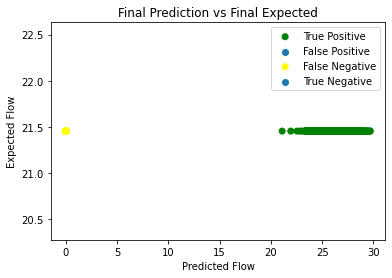

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  27.76213933849402 %	Actual Negative:  0.0 %
Positive Predicitons:  72.23786066150598 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  789    27.76213933849402 %
False Positives:  0 	 0.0 %
True Positives:  2053 	 72.23786066150598 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2053    72.23786066150598 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


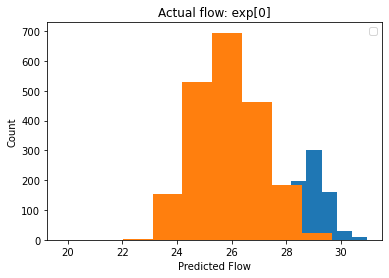

R:  -0.0 %  R^2:  0.0 %


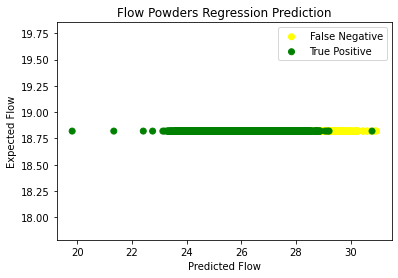

R:  -0.0 %  R^2:  0.0 %


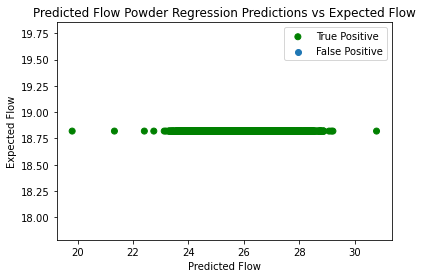

R:  0.0 %  R^2:  0.0 %


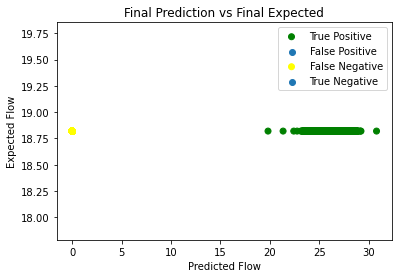

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  82.86418015482054 %	Actual Negative:  100.0 %
Positive Predicitons:  17.13581984517945 %	Actual Positive:  0.0 %

True Negatives:  2355 	 82.86418015482054 %
False Negatives:  0    0.0 %
False Positives:  487 	 17.13581984517945 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2355    82.86418015482054 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


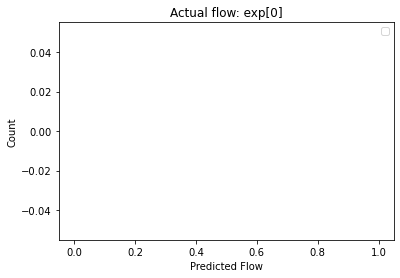

R:  nan %  R^2:  nan %


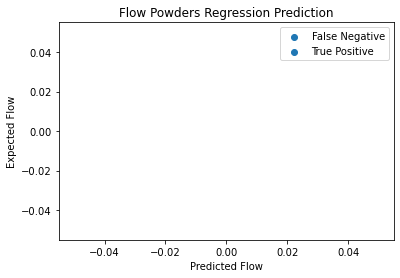

R:  nan %  R^2:  nan %


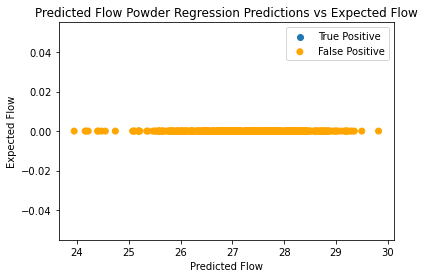

R:  nan %  R^2:  nan %


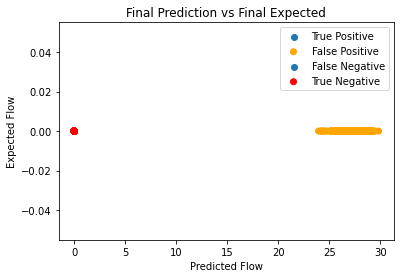

R:  nan %  R^2:  nan %
1333/1333 [==============================] - 2s 2ms/step - loss: 221037.0625
Epoch 1/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2563
Epoch 2/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2262
Epoch 3/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2238
Epoch 4/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2241
Epoch 5/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2217
Epoch 6/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2215
Epoch 7/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2204
Epoch 8/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2191
Epoch 9/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2187
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 1435918.0000
Epoch 1/10
622/622 [==============================] - 1s 2ms/step

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  38.388458831808585 %	Actual Negative:  0.0 %
Positive Predicitons:  61.61154116819142 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1091    38.388458831808585 %
False Positives:  0 	 0.0 %
True Positives:  1751 	 61.61154116819142 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1751    61.61154116819142 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


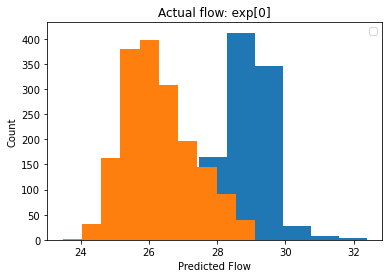

R:  nan %  R^2:  nan %


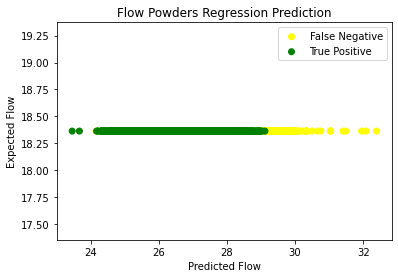

R:  nan %  R^2:  nan %


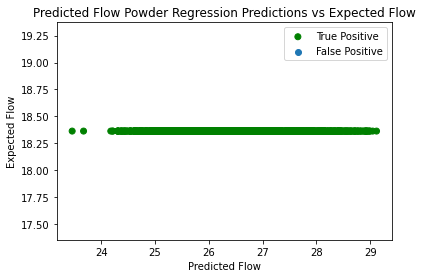

R:  0.0 %  R^2:  0.0 %


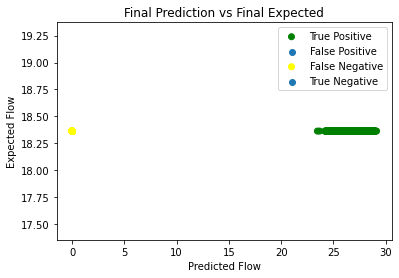

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  87.64954257565095 %	Actual Negative:  100.0 %
Positive Predicitons:  12.35045742434905 %	Actual Positive:  0.0 %

True Negatives:  2491 	 87.64954257565095 %
False Negatives:  0    0.0 %
False Positives:  351 	 12.35045742434905 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2491    87.64954257565095 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


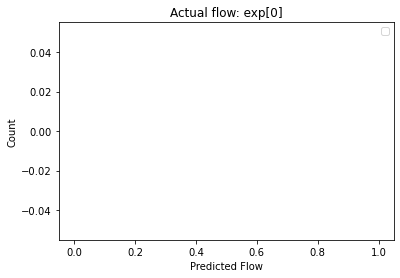

R:  nan %  R^2:  nan %


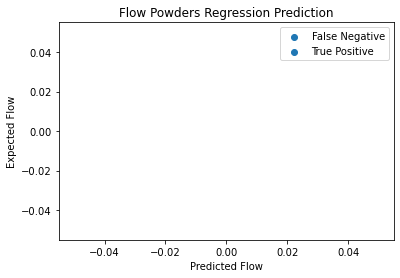

R:  nan %  R^2:  nan %


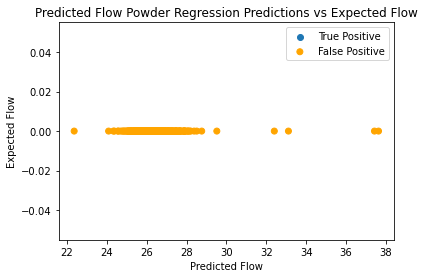

R:  nan %  R^2:  nan %


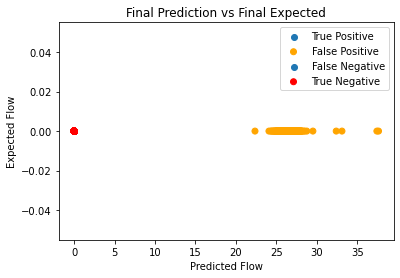

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  76.60098522167488 %	Actual Negative:  100.0 %
Positive Predicitons:  23.39901477832512 %	Actual Positive:  0.0 %

True Negatives:  2177 	 76.60098522167488 %
False Negatives:  0    0.0 %
False Positives:  665 	 23.39901477832512 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2177    76.60098522167488 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


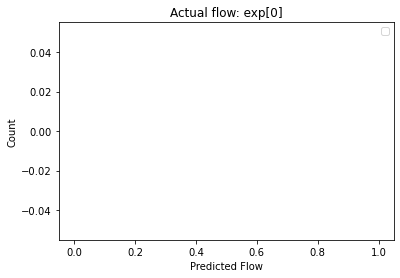

R:  nan %  R^2:  nan %


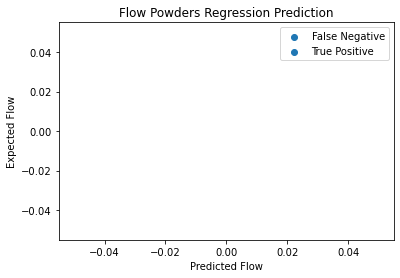

R:  nan %  R^2:  nan %


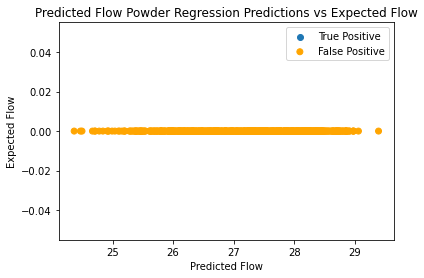

R:  nan %  R^2:  nan %


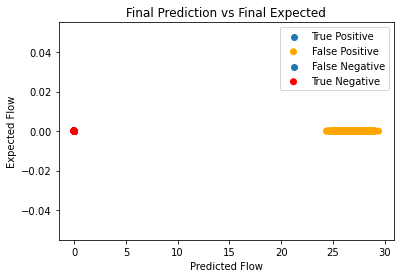

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  77.6917663617171 %	Actual Negative:  100.0 %
Positive Predicitons:  22.3082336382829 %	Actual Positive:  0.0 %

True Negatives:  2208 	 77.6917663617171 %
False Negatives:  0    0.0 %
False Positives:  634 	 22.3082336382829 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2208    77.6917663617171 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


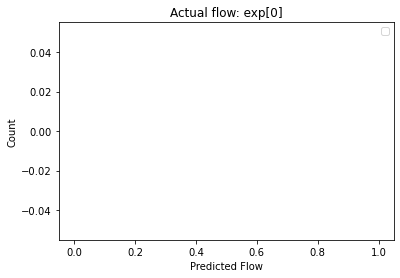

R:  nan %  R^2:  nan %


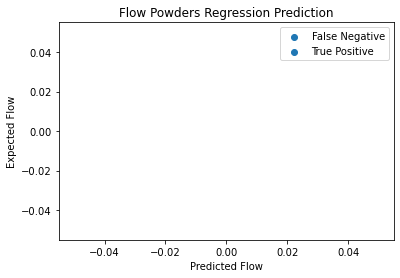

R:  nan %  R^2:  nan %


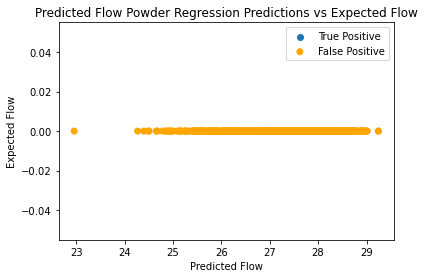

R:  nan %  R^2:  nan %


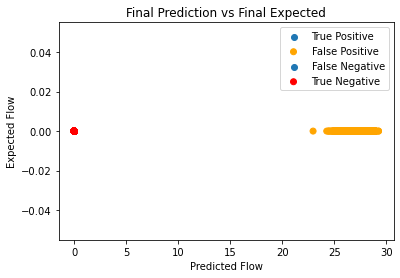

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  82.09007741027446 %	Actual Negative:  100.0 %
Positive Predicitons:  17.909922589725547 %	Actual Positive:  0.0 %

True Negatives:  2333 	 82.09007741027446 %
False Negatives:  0    0.0 %
False Positives:  509 	 17.909922589725547 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2333    82.09007741027446 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


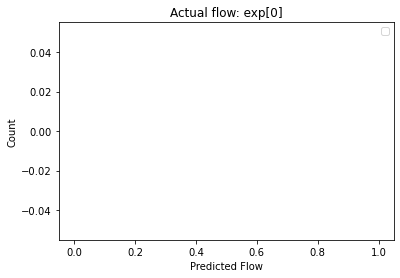

R:  nan %  R^2:  nan %


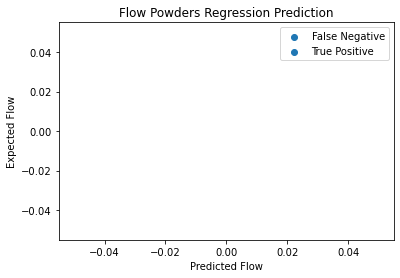

R:  nan %  R^2:  nan %


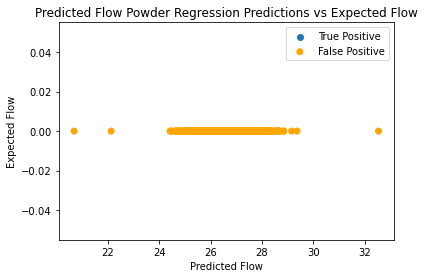

R:  nan %  R^2:  nan %


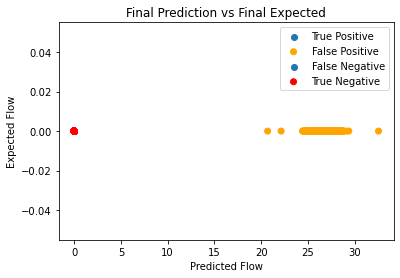

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  71.49894440534834 %	Actual Negative:  100.0 %
Positive Predicitons:  28.501055594651653 %	Actual Positive:  0.0 %

True Negatives:  2032 	 71.49894440534834 %
False Negatives:  0    0.0 %
False Positives:  810 	 28.501055594651653 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2032    71.49894440534834 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


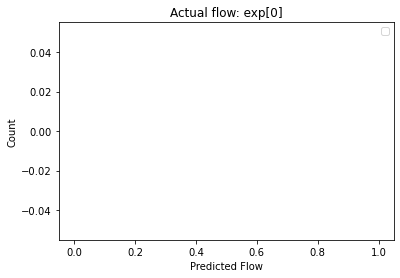

R:  nan %  R^2:  nan %


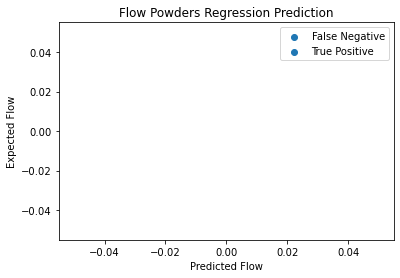

R:  nan %  R^2:  nan %


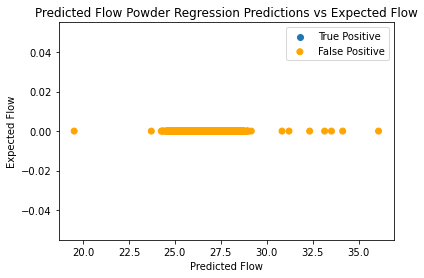

R:  nan %  R^2:  nan %


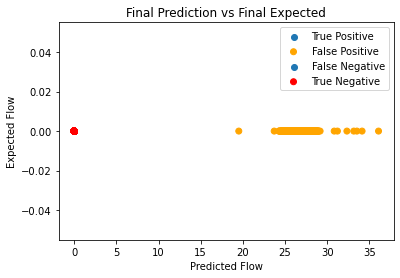

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  54.011259676284304 %	Actual Negative:  0.0 %
Positive Predicitons:  45.988740323715696 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1535    54.011259676284304 %
False Positives:  0 	 0.0 %
True Positives:  1307 	 45.988740323715696 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1307    45.988740323715696 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


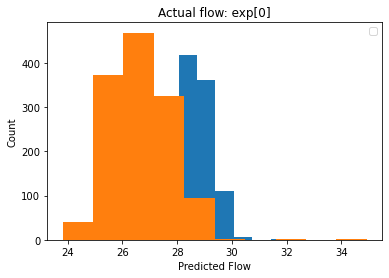

R:  nan %  R^2:  nan %


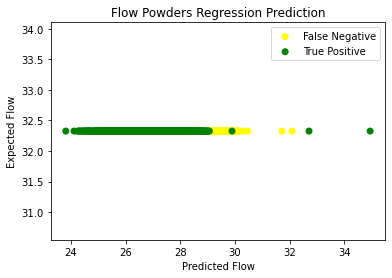

R:  nan %  R^2:  nan %


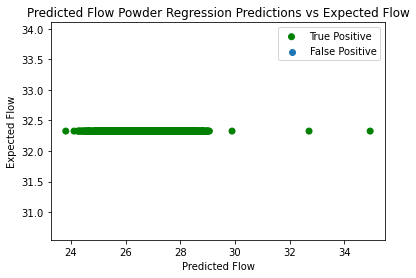

R:  nan %  R^2:  nan %


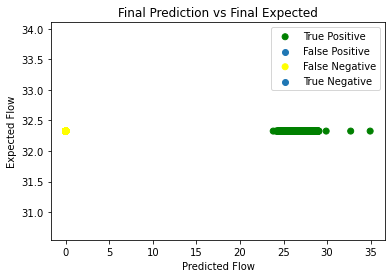

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  67.3469387755102 %	Actual Negative:  100.0 %
Positive Predicitons:  32.6530612244898 %	Actual Positive:  0.0 %

True Negatives:  1914 	 67.3469387755102 %
False Negatives:  0    0.0 %
False Positives:  928 	 32.6530612244898 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1914    67.3469387755102 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


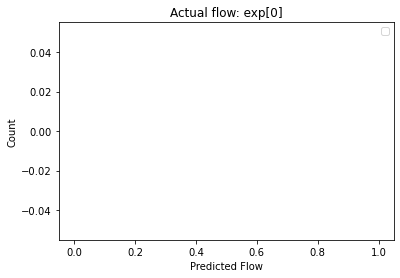

R:  nan %  R^2:  nan %


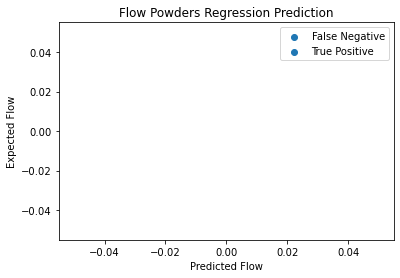

R:  nan %  R^2:  nan %


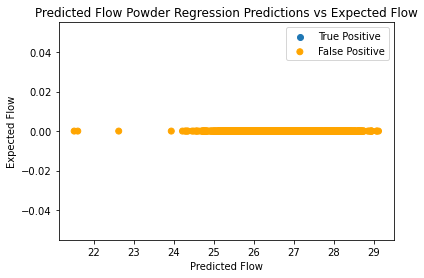

R:  nan %  R^2:  nan %


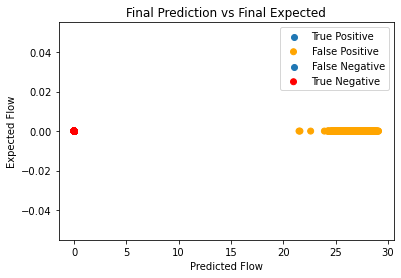

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  65.51724137931035 %	Actual Negative:  0.0 %
Positive Predicitons:  34.48275862068966 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1862    65.51724137931035 %
False Positives:  0 	 0.0 %
True Positives:  980 	 34.48275862068966 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 980    34.48275862068966 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


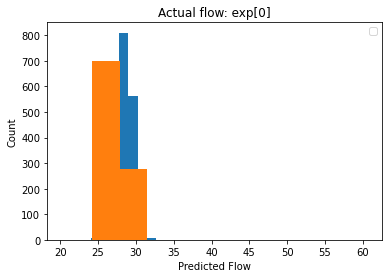

R:  nan %  R^2:  nan %


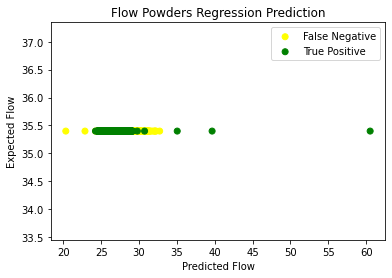

R:  nan %  R^2:  nan %


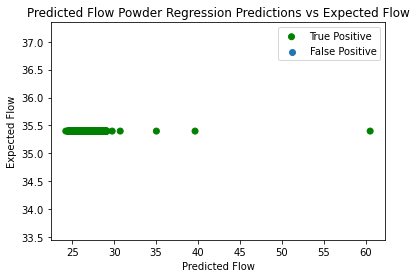

R:  0.0 %  R^2:  0.0 %


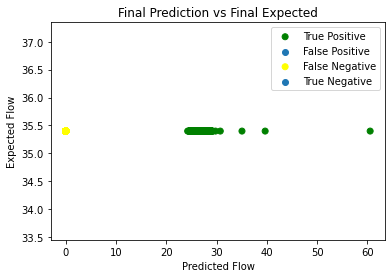

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  41.30893736805067 %	Actual Negative:  0.0 %
Positive Predicitons:  58.69106263194933 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1174    41.30893736805067 %
False Positives:  0 	 0.0 %
True Positives:  1668 	 58.69106263194933 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1668    58.69106263194933 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


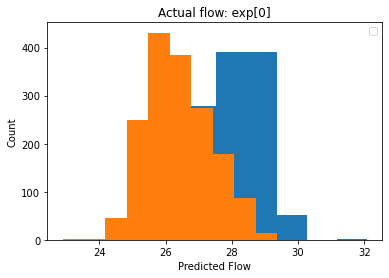

R:  0.0 %  R^2:  0.0 %


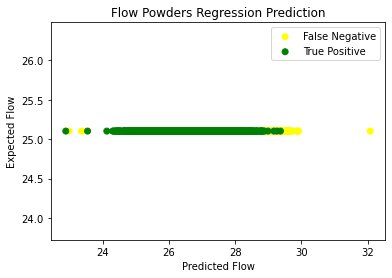

R:  0.0 %  R^2:  0.0 %


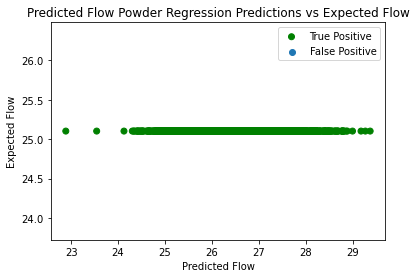

R:  -0.0 %  R^2:  0.0 %


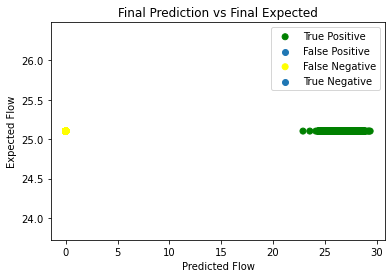

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  77.37508796622097 %	Actual Negative:  100.0 %
Positive Predicitons:  22.62491203377903 %	Actual Positive:  0.0 %

True Negatives:  2199 	 77.37508796622097 %
False Negatives:  0    0.0 %
False Positives:  643 	 22.62491203377903 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2199    77.37508796622097 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


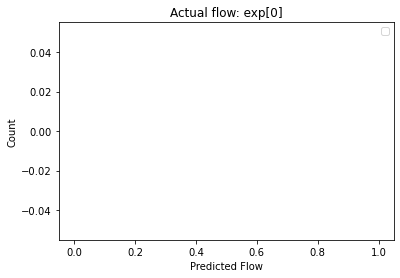

R:  nan %  R^2:  nan %


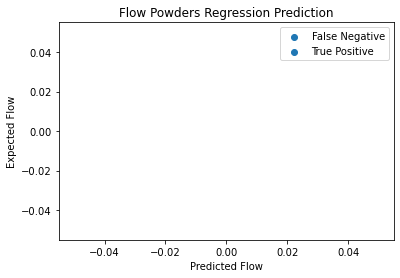

R:  nan %  R^2:  nan %


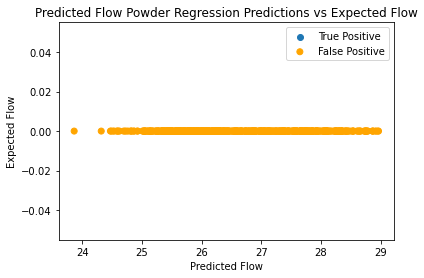

R:  nan %  R^2:  nan %


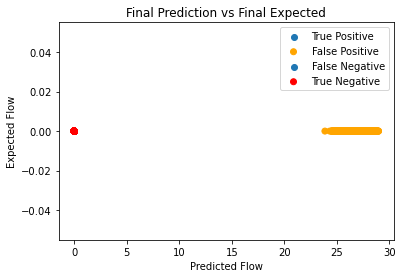

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  57.03729767769177 %	Actual Negative:  0.0 %
Positive Predicitons:  42.96270232230823 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1621    57.03729767769177 %
False Positives:  0 	 0.0 %
True Positives:  1221 	 42.96270232230823 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1221    42.96270232230823 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


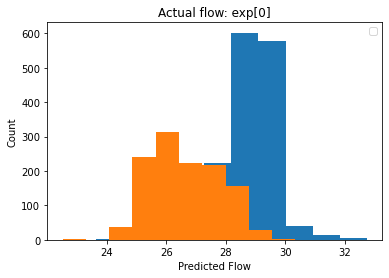

R:  nan %  R^2:  nan %


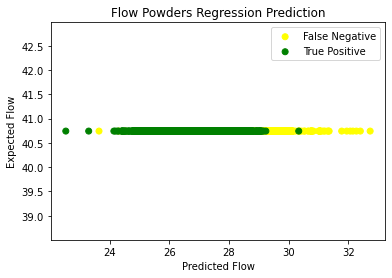

R:  nan %  R^2:  nan %


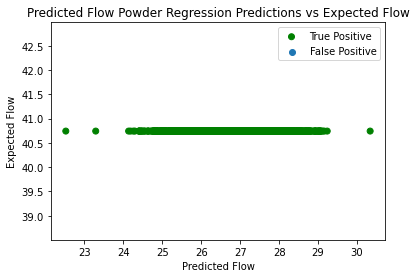

R:  nan %  R^2:  nan %


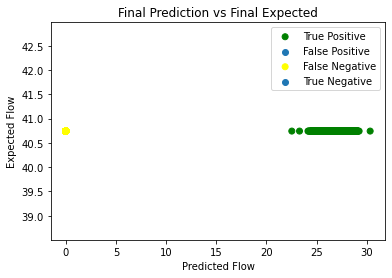

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  44.96833216045039 %	Actual Negative:  0.0 %
Positive Predicitons:  55.03166783954961 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1278    44.96833216045039 %
False Positives:  0 	 0.0 %
True Positives:  1564 	 55.03166783954961 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1564    55.03166783954961 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


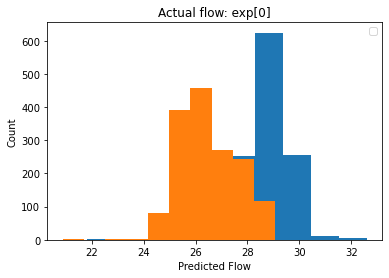

R:  -0.0 %  R^2:  0.0 %


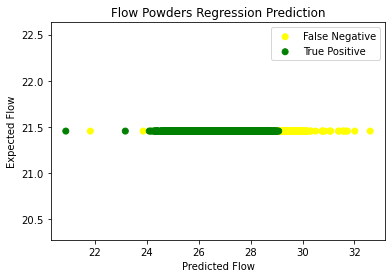

R:  -0.0 %  R^2:  0.0 %


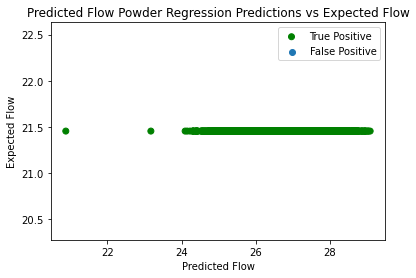

R:  0.0 %  R^2:  0.0 %


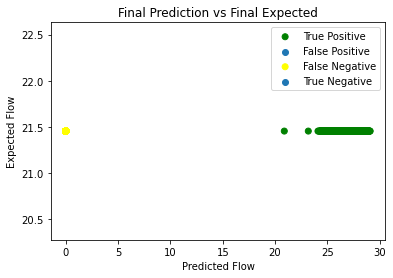

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  30.577058409570725 %	Actual Negative:  0.0 %
Positive Predicitons:  69.42294159042928 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  869    30.577058409570725 %
False Positives:  0 	 0.0 %
True Positives:  1973 	 69.42294159042928 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1973    69.42294159042928 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


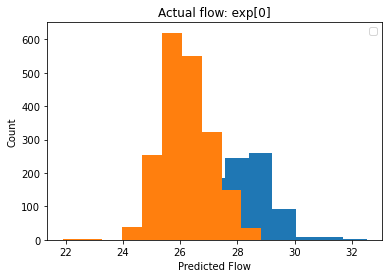

R:  -0.0 %  R^2:  0.0 %


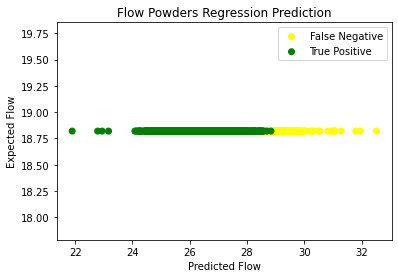

R:  -0.0 %  R^2:  0.0 %


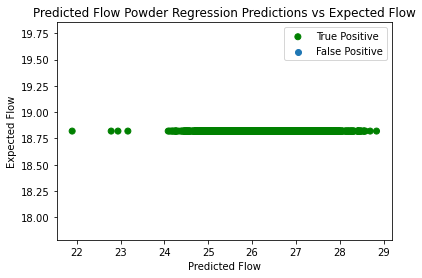

R:  0.0 %  R^2:  0.0 %


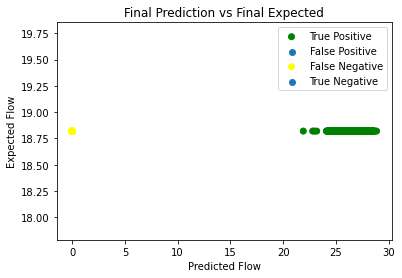

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  85.99577762139339 %	Actual Negative:  100.0 %
Positive Predicitons:  14.004222378606615 %	Actual Positive:  0.0 %

True Negatives:  2444 	 85.99577762139339 %
False Negatives:  0    0.0 %
False Positives:  398 	 14.004222378606615 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2444    85.99577762139339 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


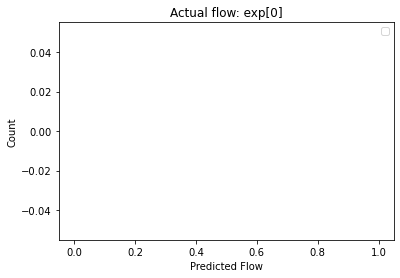

R:  nan %  R^2:  nan %


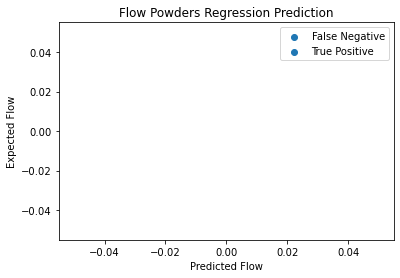

R:  nan %  R^2:  nan %


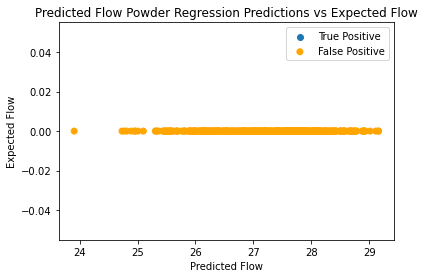

R:  nan %  R^2:  nan %


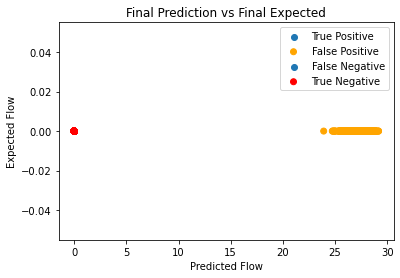

R:  nan %  R^2:  nan %
1333/1333 [==============================] - 2s 2ms/step - loss: 133690.2344
Epoch 1/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2324
Epoch 2/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2236
Epoch 3/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2213
Epoch 4/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2215
Epoch 5/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2197
Epoch 6/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2184
Epoch 7/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2185
Epoch 8/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2180
Epoch 9/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2173
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 994310.5000
Epoch 1/10
622/622 [==============================] - 1s 2ms/step 

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  36.94581280788177 %	Actual Negative:  0.0 %
Positive Predicitons:  63.05418719211823 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1050    36.94581280788177 %
False Positives:  0 	 0.0 %
True Positives:  1792 	 63.05418719211823 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1792    63.05418719211823 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


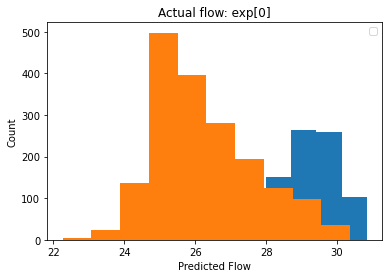

R:  nan %  R^2:  nan %


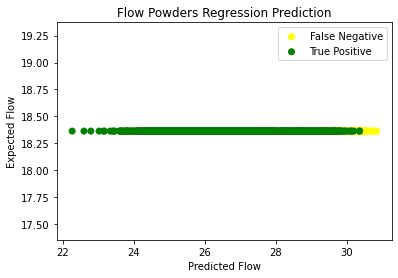

R:  nan %  R^2:  nan %


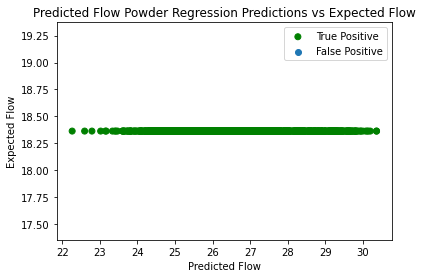

R:  0.0 %  R^2:  0.0 %


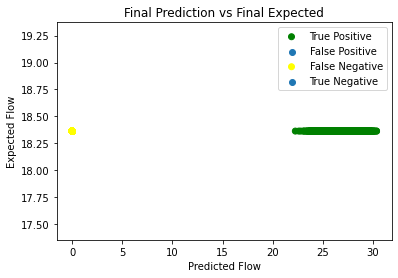

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  88.98662913441238 %	Actual Negative:  100.0 %
Positive Predicitons:  11.013370865587614 %	Actual Positive:  0.0 %

True Negatives:  2529 	 88.98662913441238 %
False Negatives:  0    0.0 %
False Positives:  313 	 11.013370865587614 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2529    88.98662913441238 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


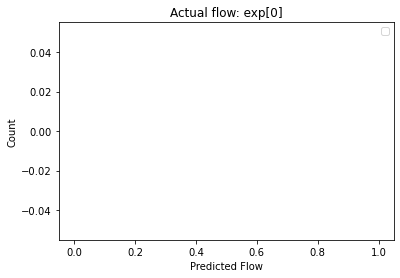

R:  nan %  R^2:  nan %


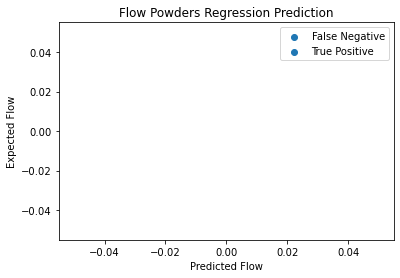

R:  nan %  R^2:  nan %


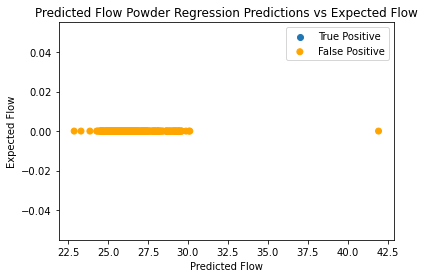

R:  nan %  R^2:  nan %


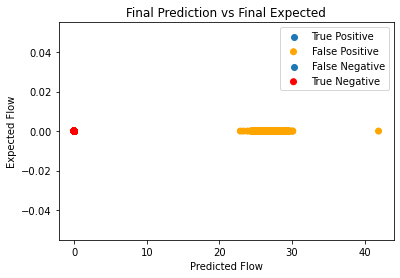

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  68.64883884588318 %	Actual Negative:  100.0 %
Positive Predicitons:  31.35116115411682 %	Actual Positive:  0.0 %

True Negatives:  1951 	 68.64883884588318 %
False Negatives:  0    0.0 %
False Positives:  891 	 31.35116115411682 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1951    68.64883884588318 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


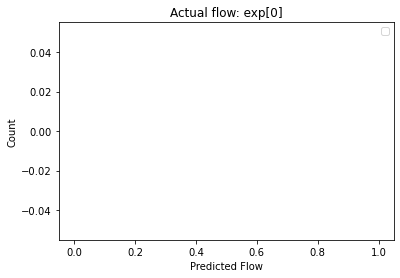

R:  nan %  R^2:  nan %


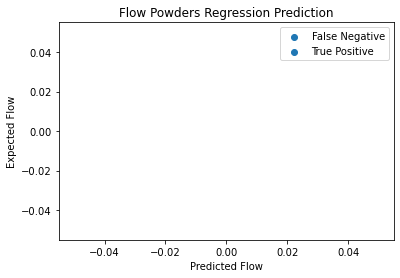

R:  nan %  R^2:  nan %


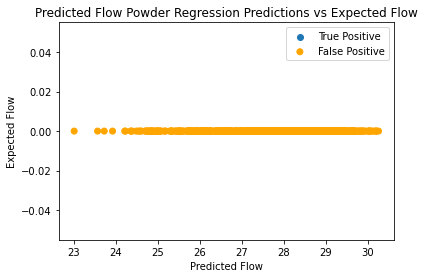

R:  nan %  R^2:  nan %


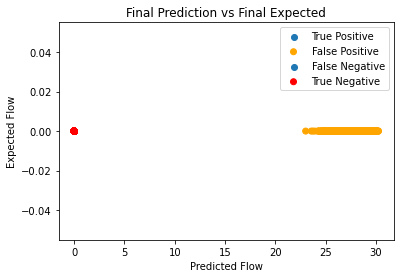

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  73.43420126671359 %	Actual Negative:  100.0 %
Positive Predicitons:  26.565798733286417 %	Actual Positive:  0.0 %

True Negatives:  2087 	 73.43420126671359 %
False Negatives:  0    0.0 %
False Positives:  755 	 26.565798733286417 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2087    73.43420126671359 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


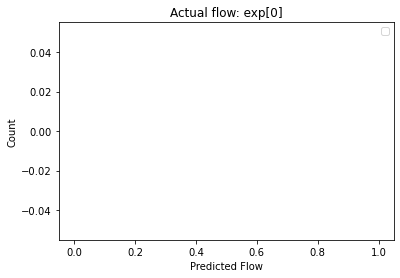

R:  nan %  R^2:  nan %


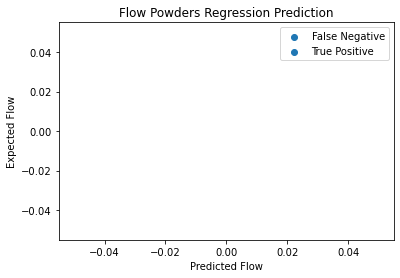

R:  nan %  R^2:  nan %


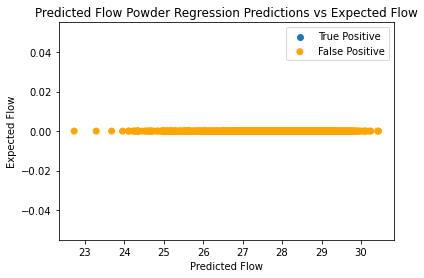

R:  nan %  R^2:  nan %


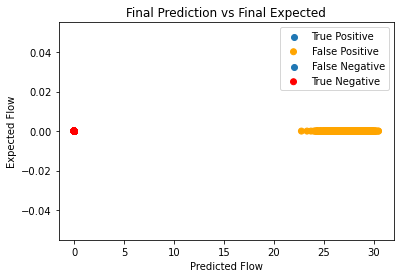

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  79.13441238564391 %	Actual Negative:  100.0 %
Positive Predicitons:  20.865587614356087 %	Actual Positive:  0.0 %

True Negatives:  2249 	 79.13441238564391 %
False Negatives:  0    0.0 %
False Positives:  593 	 20.865587614356087 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2249    79.13441238564391 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


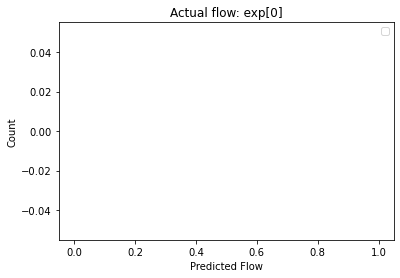

R:  nan %  R^2:  nan %


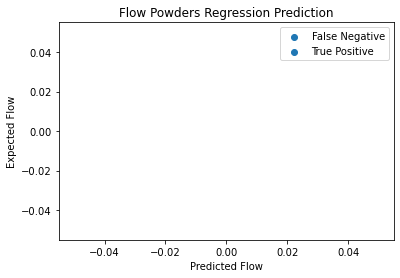

R:  nan %  R^2:  nan %


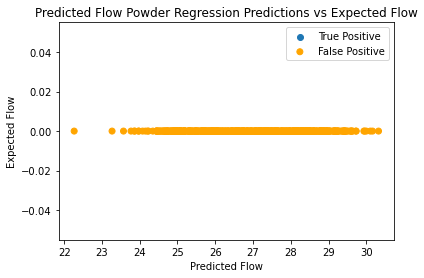

R:  nan %  R^2:  nan %


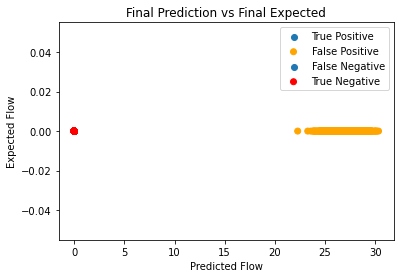

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  67.59324419422941 %	Actual Negative:  100.0 %
Positive Predicitons:  32.40675580577058 %	Actual Positive:  0.0 %

True Negatives:  1921 	 67.59324419422941 %
False Negatives:  0    0.0 %
False Positives:  921 	 32.40675580577058 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1921    67.59324419422941 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


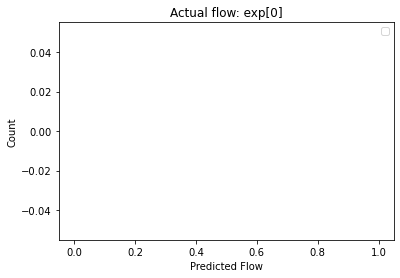

R:  nan %  R^2:  nan %


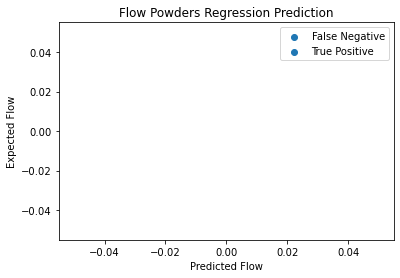

R:  nan %  R^2:  nan %


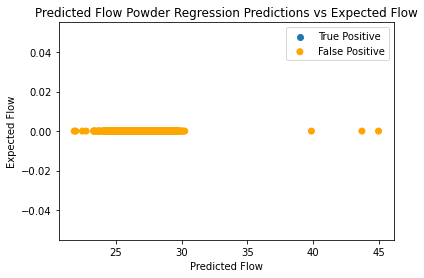

R:  nan %  R^2:  nan %


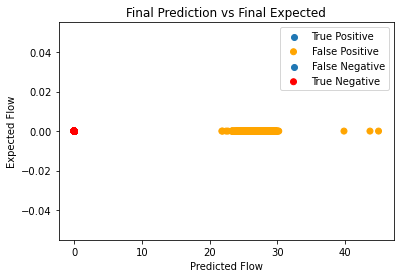

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  48.2054890921886 %	Actual Negative:  0.0 %
Positive Predicitons:  51.7945109078114 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1370    48.2054890921886 %
False Positives:  0 	 0.0 %
True Positives:  1472 	 51.7945109078114 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1472    51.7945109078114 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


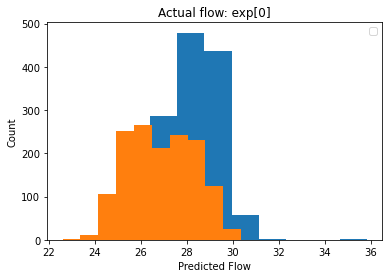

R:  nan %  R^2:  nan %


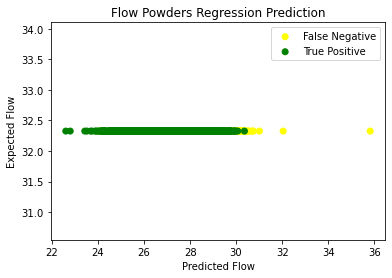

R:  nan %  R^2:  nan %


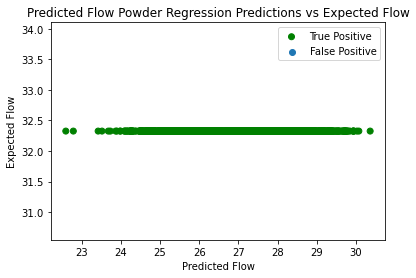

R:  -0.0 %  R^2:  0.0 %


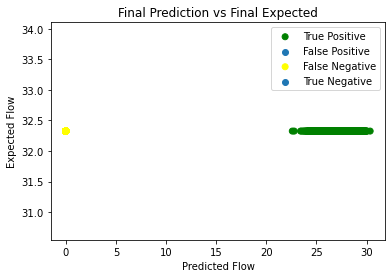

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  63.68754398311049 %	Actual Negative:  100.0 %
Positive Predicitons:  36.31245601688951 %	Actual Positive:  0.0 %

True Negatives:  1810 	 63.68754398311049 %
False Negatives:  0    0.0 %
False Positives:  1032 	 36.31245601688951 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1810    63.68754398311049 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


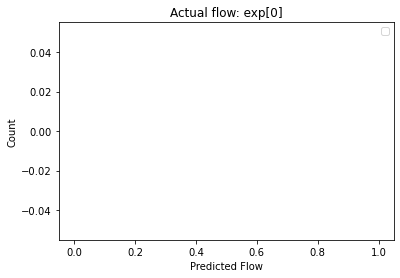

R:  nan %  R^2:  nan %


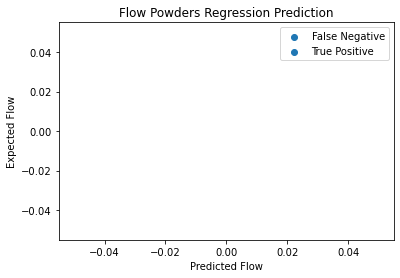

R:  nan %  R^2:  nan %


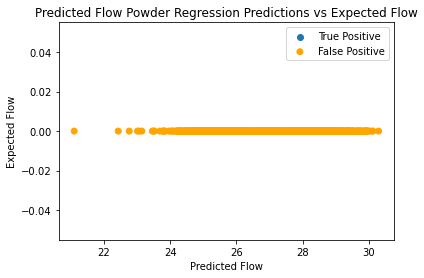

R:  nan %  R^2:  nan %


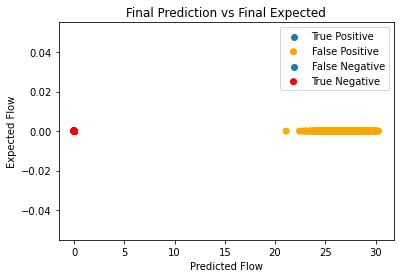

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  57.21323011963406 %	Actual Negative:  0.0 %
Positive Predicitons:  42.78676988036594 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1626    57.21323011963406 %
False Positives:  0 	 0.0 %
True Positives:  1216 	 42.78676988036594 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1216    42.78676988036594 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


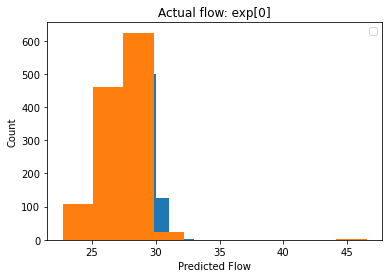

R:  nan %  R^2:  nan %


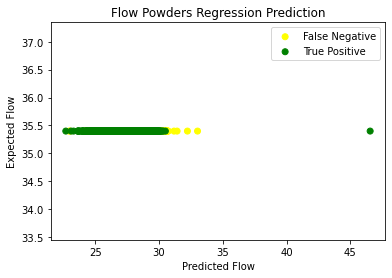

R:  nan %  R^2:  nan %


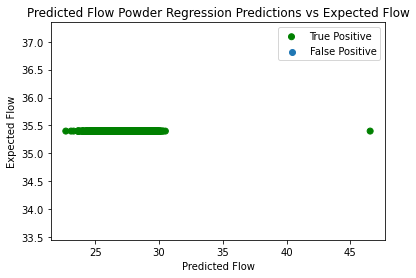

R:  nan %  R^2:  nan %


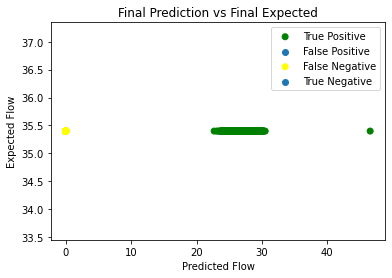

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  39.86629134412386 %	Actual Negative:  0.0 %
Positive Predicitons:  60.13370865587614 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1133    39.86629134412386 %
False Positives:  0 	 0.0 %
True Positives:  1709 	 60.13370865587614 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1709    60.13370865587614 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


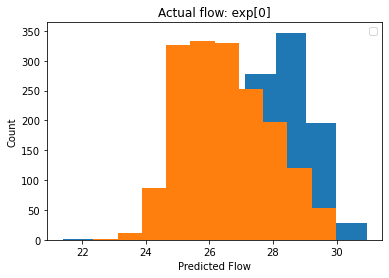

R:  -0.0 %  R^2:  0.0 %


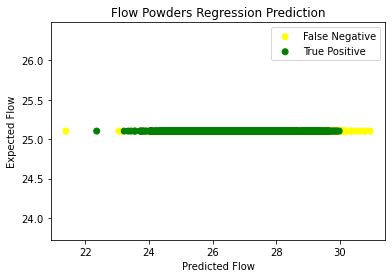

R:  -0.0 %  R^2:  0.0 %


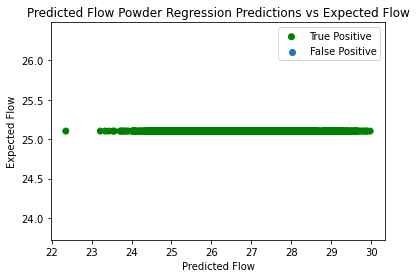

R:  nan %  R^2:  nan %


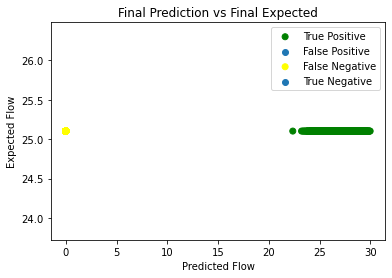

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  75.43983110485574 %	Actual Negative:  100.0 %
Positive Predicitons:  24.560168895144265 %	Actual Positive:  0.0 %

True Negatives:  2144 	 75.43983110485574 %
False Negatives:  0    0.0 %
False Positives:  698 	 24.560168895144265 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2144    75.43983110485574 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


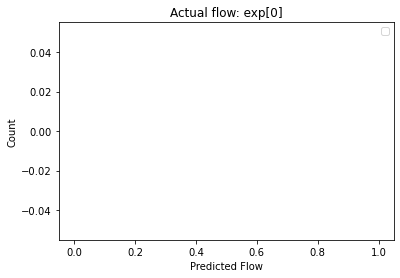

R:  nan %  R^2:  nan %


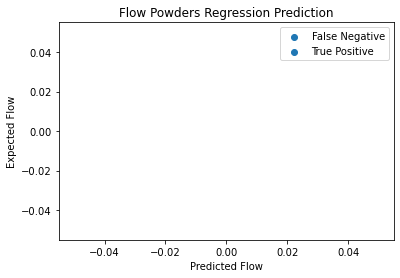

R:  nan %  R^2:  nan %


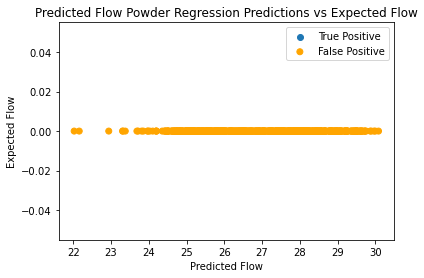

R:  nan %  R^2:  nan %


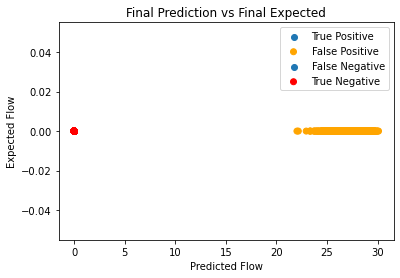

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  53.624208304011255 %	Actual Negative:  0.0 %
Positive Predicitons:  46.37579169598874 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1524    53.624208304011255 %
False Positives:  0 	 0.0 %
True Positives:  1318 	 46.37579169598874 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1318    46.37579169598874 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


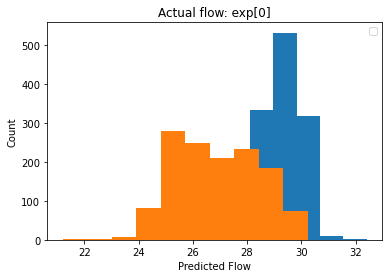

R:  nan %  R^2:  nan %


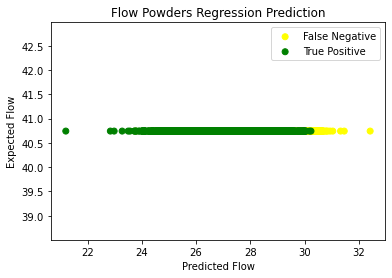

R:  nan %  R^2:  nan %


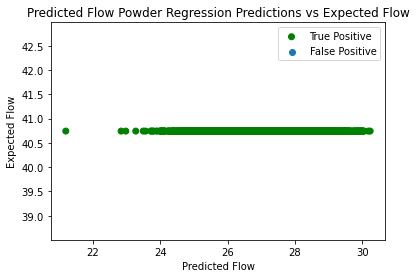

R:  nan %  R^2:  nan %


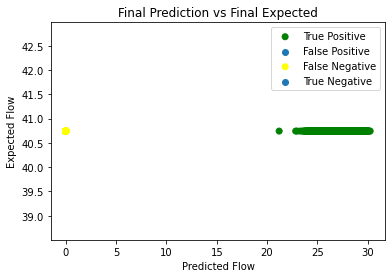

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  37.895847994370165 %	Actual Negative:  0.0 %
Positive Predicitons:  62.10415200562984 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1077    37.895847994370165 %
False Positives:  0 	 0.0 %
True Positives:  1765 	 62.10415200562984 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1765    62.10415200562984 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


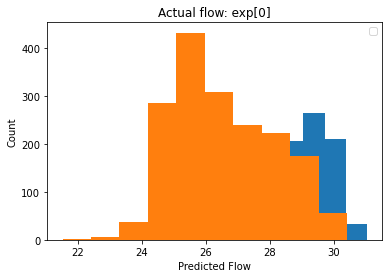

R:  0.0 %  R^2:  0.0 %


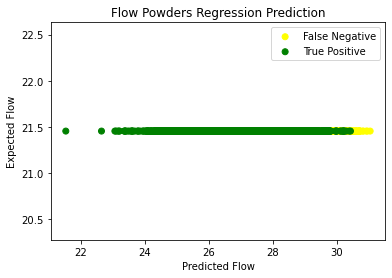

R:  0.0 %  R^2:  0.0 %


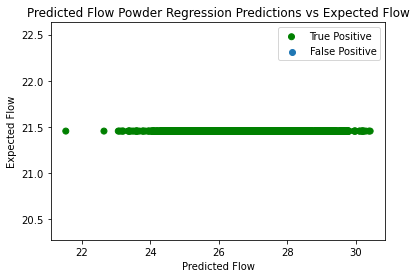

R:  -0.0 %  R^2:  0.0 %


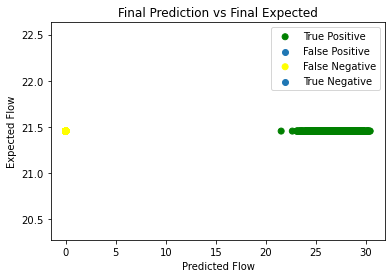

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  33.60309641097818 %	Actual Negative:  0.0 %
Positive Predicitons:  66.39690358902182 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  955    33.60309641097818 %
False Positives:  0 	 0.0 %
True Positives:  1887 	 66.39690358902182 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1887    66.39690358902182 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


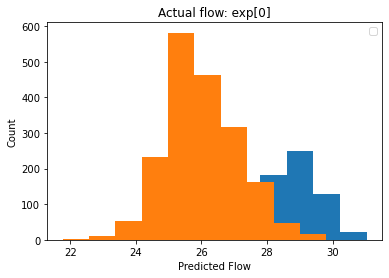

R:  0.0 %  R^2:  0.0 %


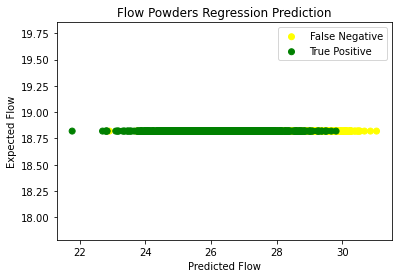

R:  0.0 %  R^2:  0.0 %


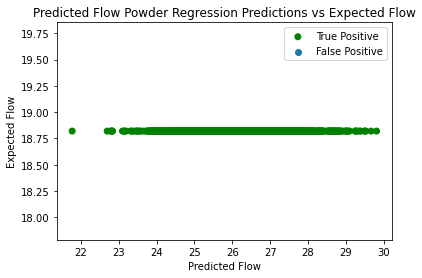

R:  0.0 %  R^2:  0.0 %


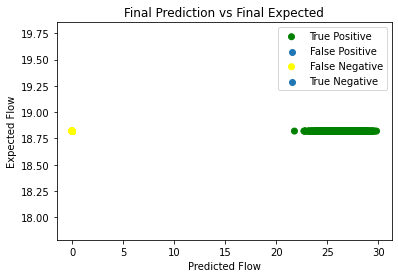

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  82.19563687543983 %	Actual Negative:  100.0 %
Positive Predicitons:  17.80436312456017 %	Actual Positive:  0.0 %

True Negatives:  2336 	 82.19563687543983 %
False Negatives:  0    0.0 %
False Positives:  506 	 17.80436312456017 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2336    82.19563687543983 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


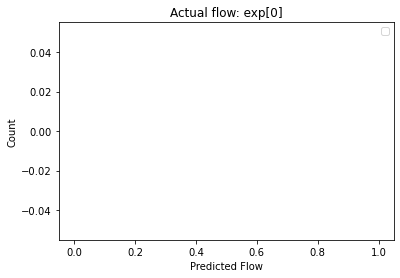

R:  nan %  R^2:  nan %


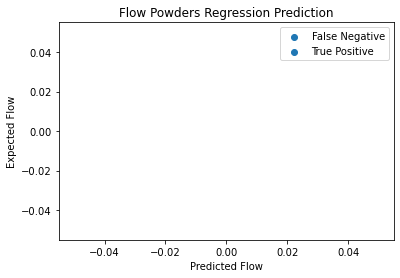

R:  nan %  R^2:  nan %


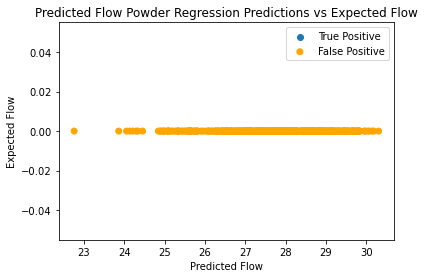

R:  nan %  R^2:  nan %


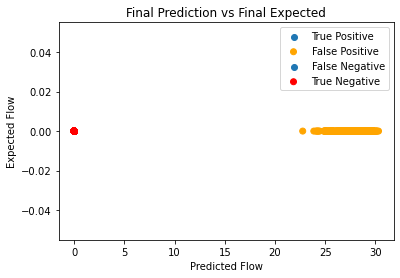

R:  nan %  R^2:  nan %
1333/1333 [==============================] - 2s 2ms/step - loss: 200110.3594
Epoch 1/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2365
Epoch 2/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2253
Epoch 3/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2235
Epoch 4/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2213
Epoch 5/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2208
Epoch 6/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2202
Epoch 7/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2199
Epoch 8/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2181
Epoch 9/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2183
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 4409967.5000
Epoch 1/10
622/622 [==============================] - 1s 2ms/step

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  34.90499648135116 %	Actual Negative:  0.0 %
Positive Predicitons:  65.09500351864884 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  992    34.90499648135116 %
False Positives:  0 	 0.0 %
True Positives:  1850 	 65.09500351864884 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1850    65.09500351864884 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


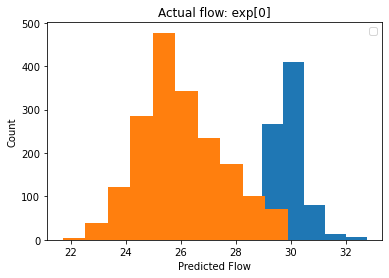

R:  nan %  R^2:  nan %


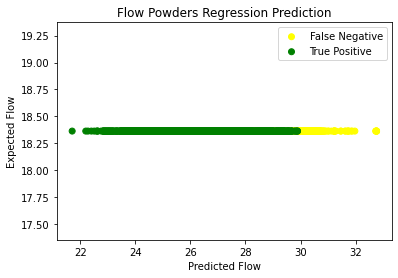

R:  nan %  R^2:  nan %


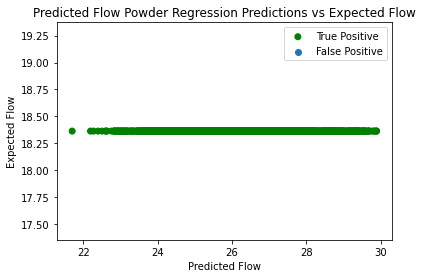

R:  -0.0 %  R^2:  0.0 %


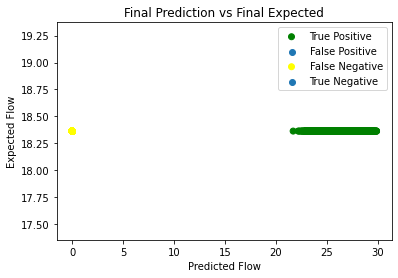

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  84.8698099929627 %	Actual Negative:  100.0 %
Positive Predicitons:  15.130190007037298 %	Actual Positive:  0.0 %

True Negatives:  2412 	 84.8698099929627 %
False Negatives:  0    0.0 %
False Positives:  430 	 15.130190007037298 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2412    84.8698099929627 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


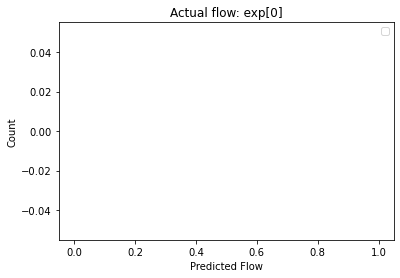

R:  nan %  R^2:  nan %


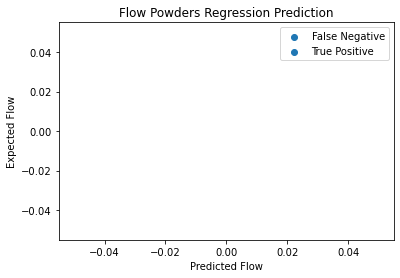

R:  nan %  R^2:  nan %


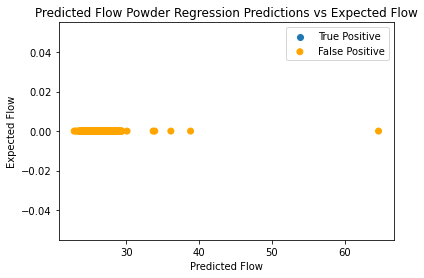

R:  nan %  R^2:  nan %


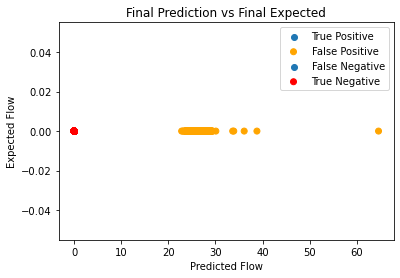

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  70.90077410274455 %	Actual Negative:  100.0 %
Positive Predicitons:  29.099225897255454 %	Actual Positive:  0.0 %

True Negatives:  2015 	 70.90077410274455 %
False Negatives:  0    0.0 %
False Positives:  827 	 29.099225897255454 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2015    70.90077410274455 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


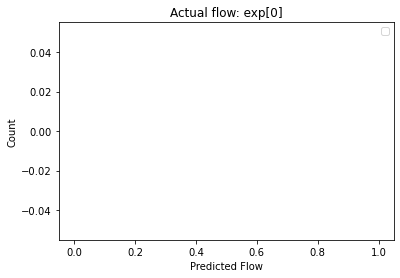

R:  nan %  R^2:  nan %


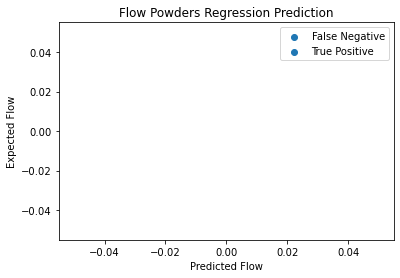

R:  nan %  R^2:  nan %


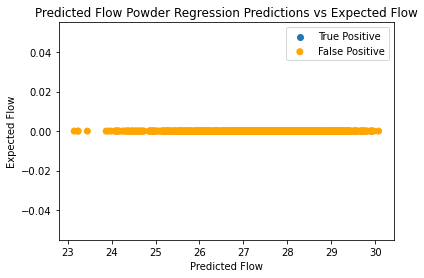

R:  nan %  R^2:  nan %


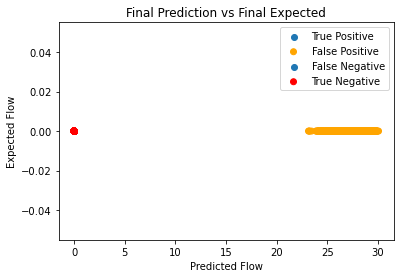

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  71.78043631245602 %	Actual Negative:  100.0 %
Positive Predicitons:  28.21956368754398 %	Actual Positive:  0.0 %

True Negatives:  2040 	 71.78043631245602 %
False Negatives:  0    0.0 %
False Positives:  802 	 28.21956368754398 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2040    71.78043631245602 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


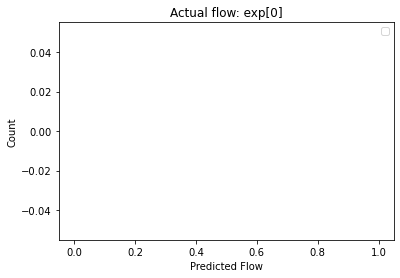

R:  nan %  R^2:  nan %


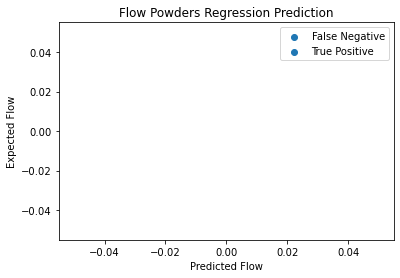

R:  nan %  R^2:  nan %


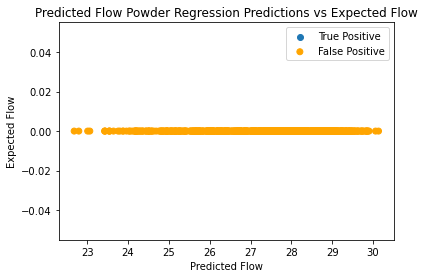

R:  nan %  R^2:  nan %


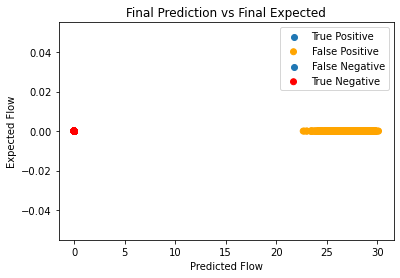

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  76.98803659394792 %	Actual Negative:  100.0 %
Positive Predicitons:  23.01196340605208 %	Actual Positive:  0.0 %

True Negatives:  2188 	 76.98803659394792 %
False Negatives:  0    0.0 %
False Positives:  654 	 23.01196340605208 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2188    76.98803659394792 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


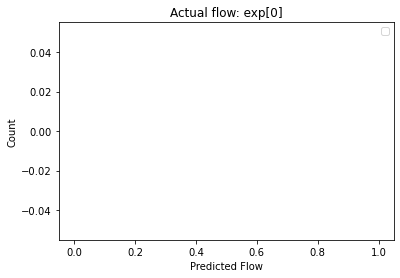

R:  nan %  R^2:  nan %


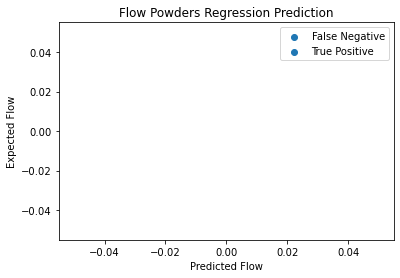

R:  nan %  R^2:  nan %


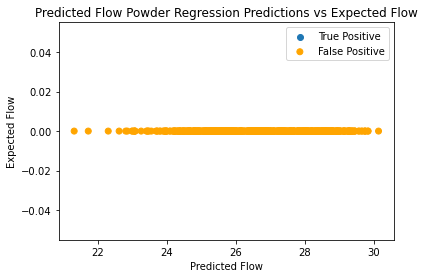

R:  nan %  R^2:  nan %


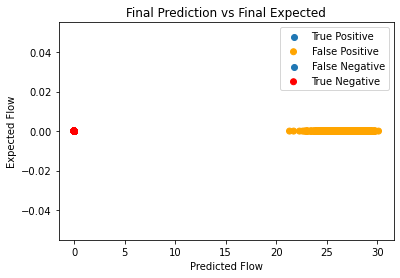

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  67.38212526389866 %	Actual Negative:  100.0 %
Positive Predicitons:  32.617874736101335 %	Actual Positive:  0.0 %

True Negatives:  1915 	 67.38212526389866 %
False Negatives:  0    0.0 %
False Positives:  927 	 32.617874736101335 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1915    67.38212526389866 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


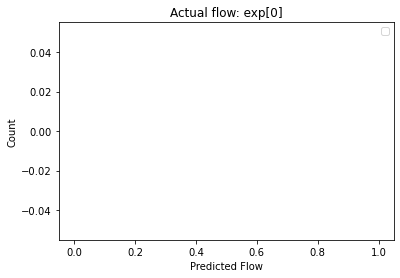

R:  nan %  R^2:  nan %


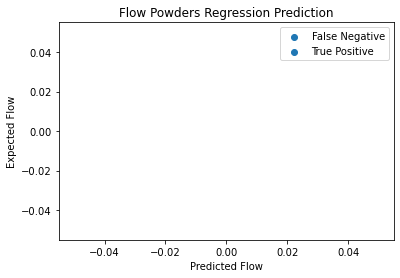

R:  nan %  R^2:  nan %


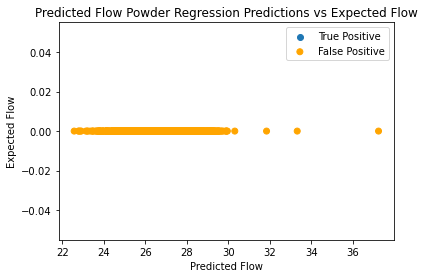

R:  nan %  R^2:  nan %


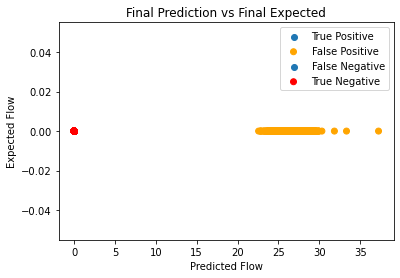

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  45.67206192821956 %	Actual Negative:  0.0 %
Positive Predicitons:  54.32793807178044 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1298    45.67206192821956 %
False Positives:  0 	 0.0 %
True Positives:  1544 	 54.32793807178044 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1544    54.32793807178044 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


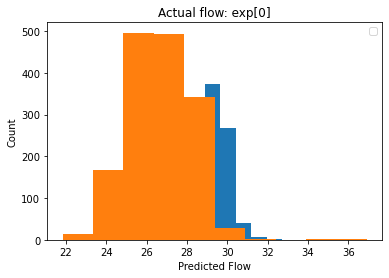

R:  nan %  R^2:  nan %


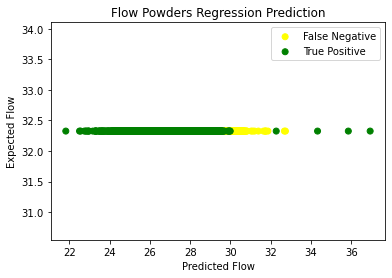

R:  nan %  R^2:  nan %


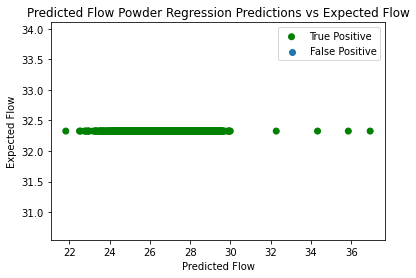

R:  nan %  R^2:  nan %


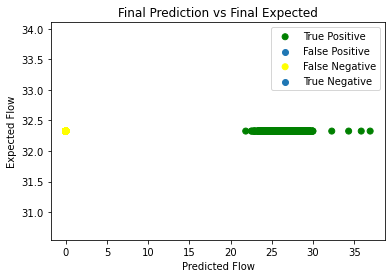

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  62.350457424349045 %	Actual Negative:  100.0 %
Positive Predicitons:  37.649542575650955 %	Actual Positive:  0.0 %

True Negatives:  1772 	 62.350457424349045 %
False Negatives:  0    0.0 %
False Positives:  1070 	 37.649542575650955 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1772    62.350457424349045 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


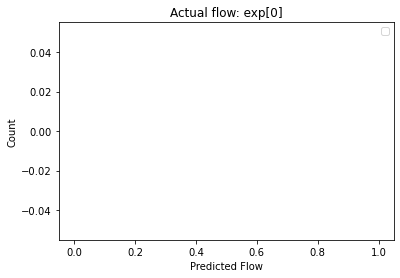

R:  nan %  R^2:  nan %


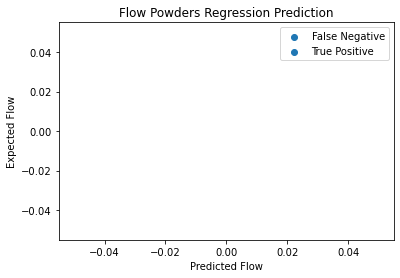

R:  nan %  R^2:  nan %


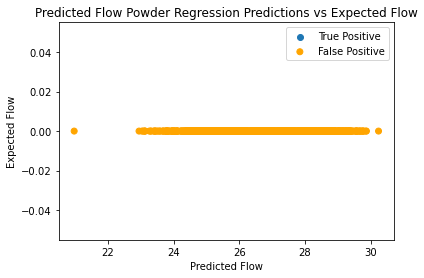

R:  nan %  R^2:  nan %


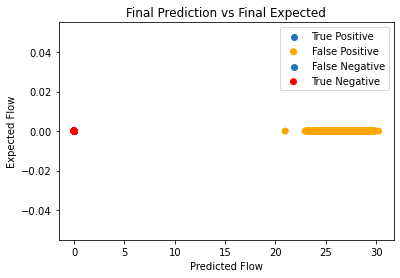

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  59.00774102744546 %	Actual Negative:  0.0 %
Positive Predicitons:  40.99225897255454 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1677    59.00774102744546 %
False Positives:  0 	 0.0 %
True Positives:  1165 	 40.99225897255454 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1165    40.99225897255454 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


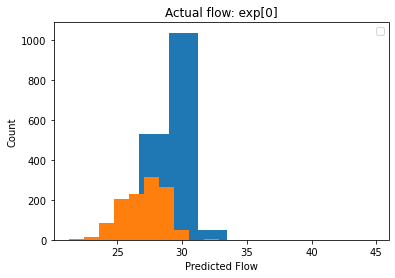

R:  nan %  R^2:  nan %


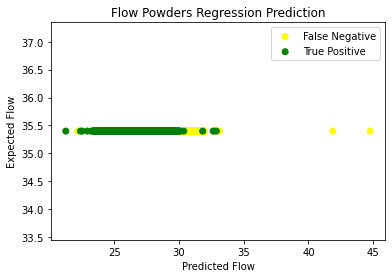

R:  nan %  R^2:  nan %


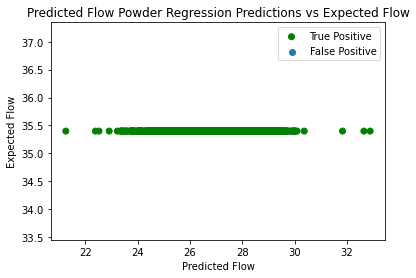

R:  nan %  R^2:  nan %


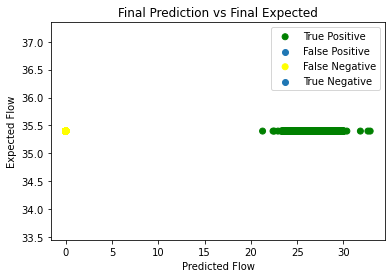

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  35.11611541168192 %	Actual Negative:  0.0 %
Positive Predicitons:  64.88388458831808 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  998    35.11611541168192 %
False Positives:  0 	 0.0 %
True Positives:  1844 	 64.88388458831808 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1844    64.88388458831808 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


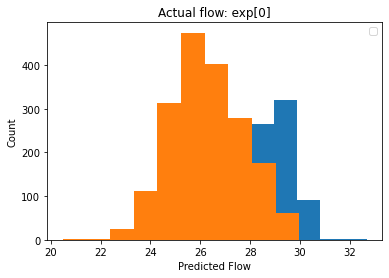

R:  -0.0 %  R^2:  0.0 %


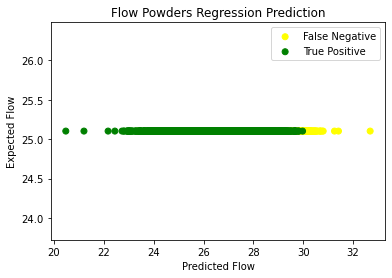

R:  -0.0 %  R^2:  0.0 %


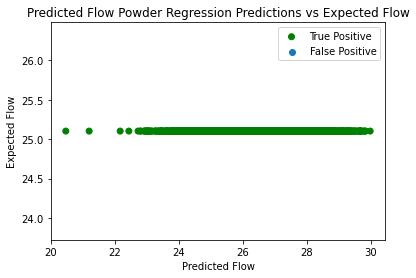

R:  nan %  R^2:  nan %


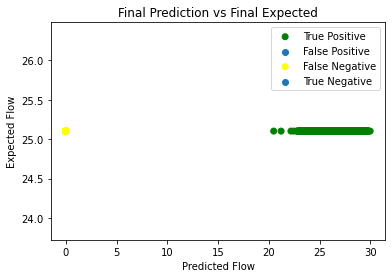

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  73.926812104152 %	Actual Negative:  100.0 %
Positive Predicitons:  26.073187895847994 %	Actual Positive:  0.0 %

True Negatives:  2101 	 73.926812104152 %
False Negatives:  0    0.0 %
False Positives:  741 	 26.073187895847994 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2101    73.926812104152 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


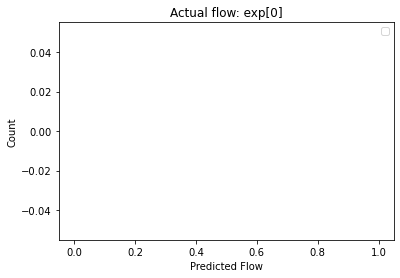

R:  nan %  R^2:  nan %


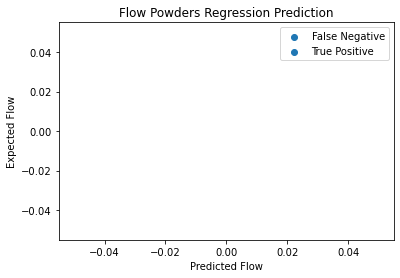

R:  nan %  R^2:  nan %


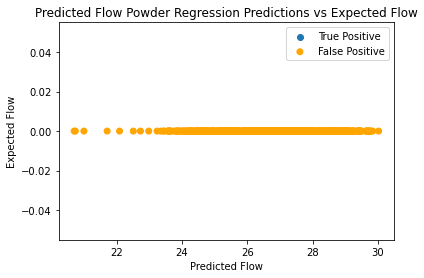

R:  nan %  R^2:  nan %


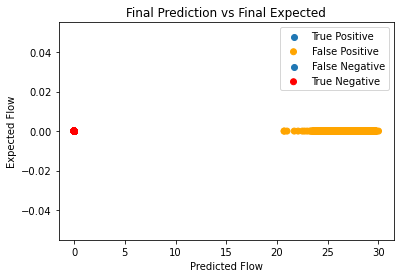

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  52.85010555946516 %	Actual Negative:  0.0 %
Positive Predicitons:  47.14989444053484 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1502    52.85010555946516 %
False Positives:  0 	 0.0 %
True Positives:  1340 	 47.14989444053484 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1340    47.14989444053484 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


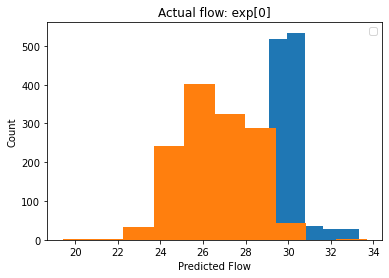

R:  nan %  R^2:  nan %


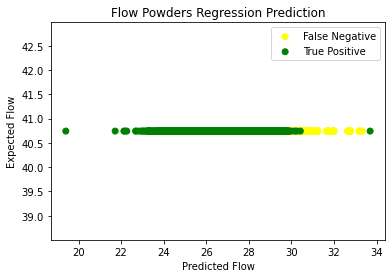

R:  nan %  R^2:  nan %


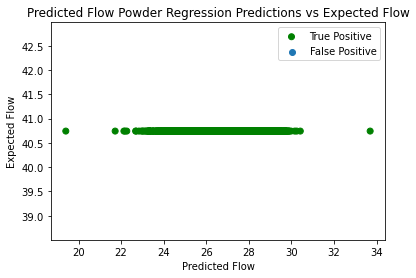

R:  nan %  R^2:  nan %


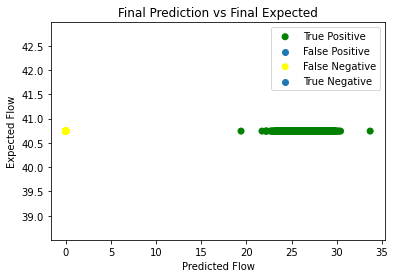

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  38.42364532019704 %	Actual Negative:  0.0 %
Positive Predicitons:  61.57635467980296 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1092    38.42364532019704 %
False Positives:  0 	 0.0 %
True Positives:  1750 	 61.57635467980296 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1750    61.57635467980296 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


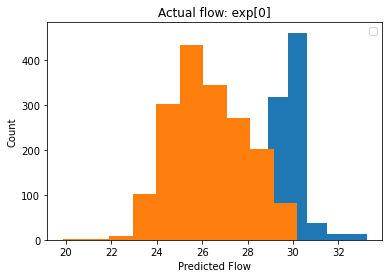

R:  -0.0 %  R^2:  0.0 %


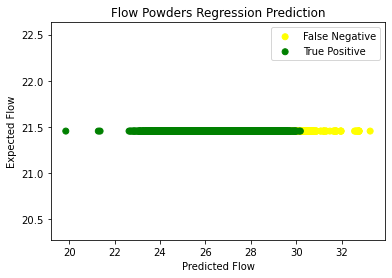

R:  -0.0 %  R^2:  0.0 %


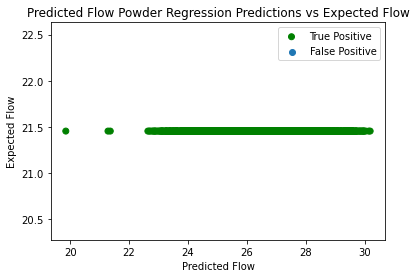

R:  0.0 %  R^2:  0.0 %


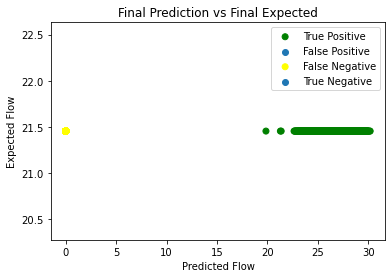

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  28.4658691062632 %	Actual Negative:  0.0 %
Positive Predicitons:  71.5341308937368 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  809    28.4658691062632 %
False Positives:  0 	 0.0 %
True Positives:  2033 	 71.5341308937368 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2033    71.5341308937368 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


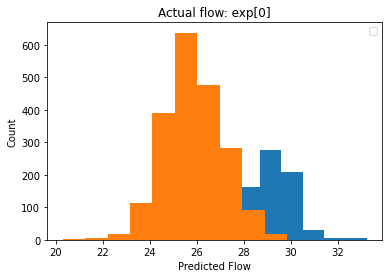

R:  0.0 %  R^2:  0.0 %


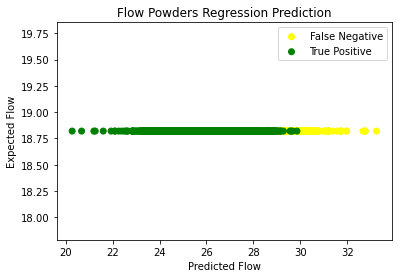

R:  0.0 %  R^2:  0.0 %


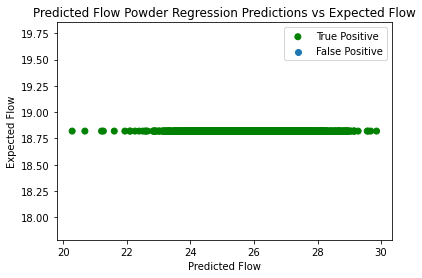

R:  nan %  R^2:  nan %


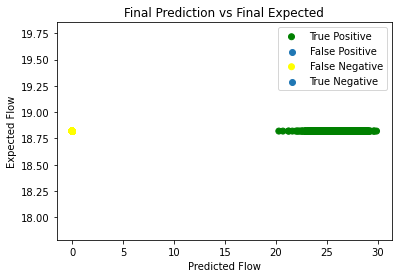

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  82.19563687543983 %	Actual Negative:  100.0 %
Positive Predicitons:  17.80436312456017 %	Actual Positive:  0.0 %

True Negatives:  2336 	 82.19563687543983 %
False Negatives:  0    0.0 %
False Positives:  506 	 17.80436312456017 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2336    82.19563687543983 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


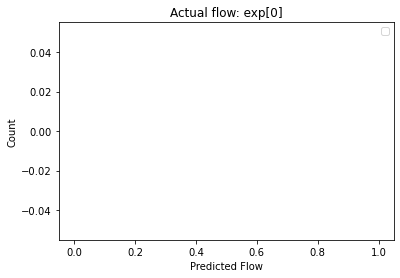

R:  nan %  R^2:  nan %


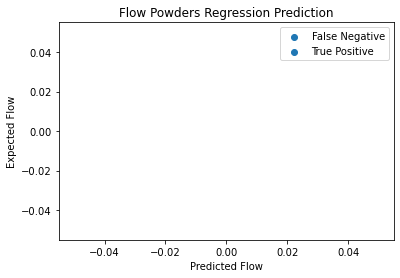

R:  nan %  R^2:  nan %


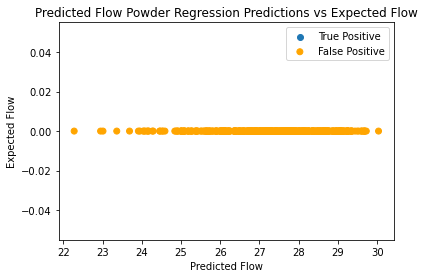

R:  nan %  R^2:  nan %


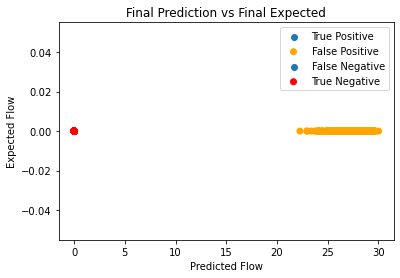

R:  nan %  R^2:  nan %
1333/1333 [==============================] - 2s 2ms/step - loss: 76819.1484
Epoch 1/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2316
Epoch 2/10
1333/1333 [==============================] - 3s 2ms/step - loss: 0.2234
Epoch 3/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 4/10
1333/1333 [==============================] - 3s 2ms/step - loss: 0.2203
Epoch 5/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2196
Epoch 6/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2178
Epoch 7/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2176
Epoch 8/10
1333/1333 [==============================] - 3s 2ms/step - loss: 0.2167
Epoch 9/10
1333/1333 [==============================] - 2s 2ms/step - loss: 0.2162
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 1383509.5000
Epoch 1/10
622/622 [==============================] - 1s 2ms/step 

C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  36.80506685432794 %	Actual Negative:  0.0 %
Positive Predicitons:  63.19493314567206 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1046    36.80506685432794 %
False Positives:  0 	 0.0 %
True Positives:  1796 	 63.19493314567206 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1796    63.19493314567206 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


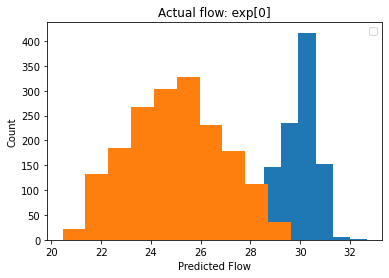

R:  nan %  R^2:  nan %


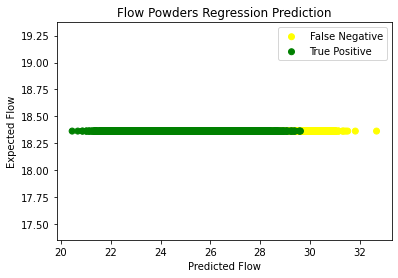

R:  nan %  R^2:  nan %


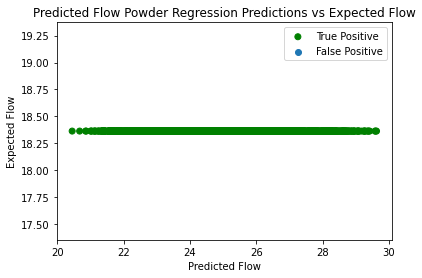

R:  nan %  R^2:  nan %


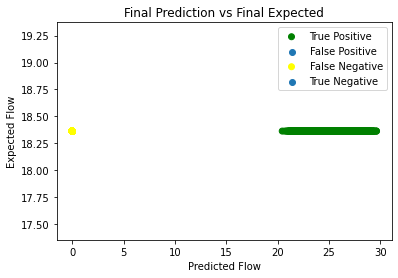

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  83.91977480647431 %	Actual Negative:  100.0 %
Positive Predicitons:  16.080225193525685 %	Actual Positive:  0.0 %

True Negatives:  2385 	 83.91977480647431 %
False Negatives:  0    0.0 %
False Positives:  457 	 16.080225193525685 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2385    83.91977480647431 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


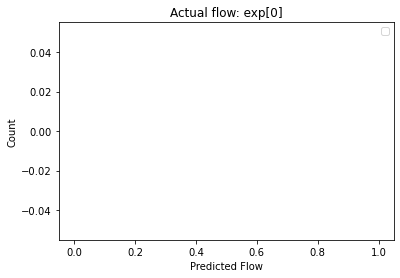

R:  nan %  R^2:  nan %


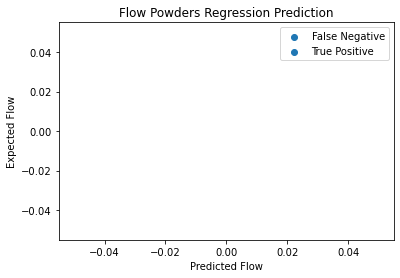

R:  nan %  R^2:  nan %


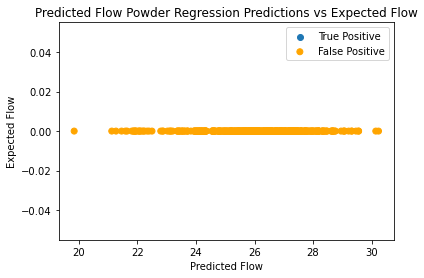

R:  nan %  R^2:  nan %


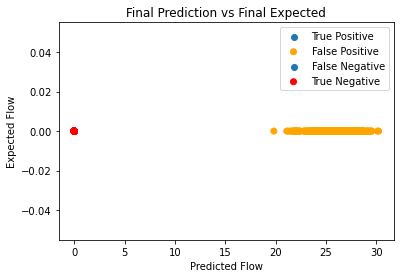

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  73.04714989444054 %	Actual Negative:  100.0 %
Positive Predicitons:  26.952850105559467 %	Actual Positive:  0.0 %

True Negatives:  2076 	 73.04714989444054 %
False Negatives:  0    0.0 %
False Positives:  766 	 26.952850105559467 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2076    73.04714989444054 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


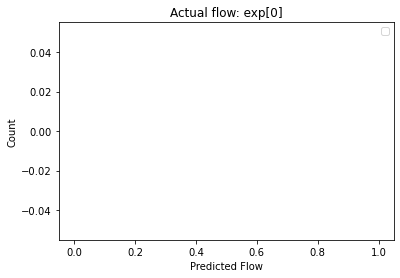

R:  nan %  R^2:  nan %


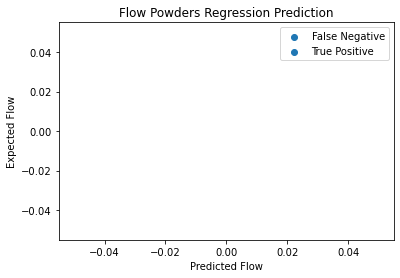

R:  nan %  R^2:  nan %


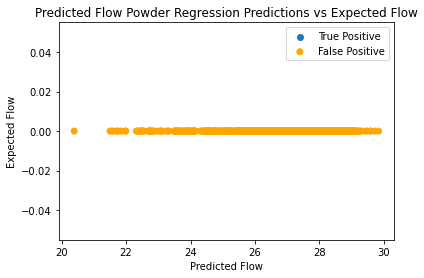

R:  nan %  R^2:  nan %


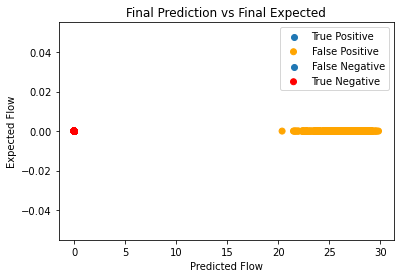

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  77.23434201266713 %	Actual Negative:  100.0 %
Positive Predicitons:  22.76565798733286 %	Actual Positive:  0.0 %

True Negatives:  2195 	 77.23434201266713 %
False Negatives:  0    0.0 %
False Positives:  647 	 22.76565798733286 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2195    77.23434201266713 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


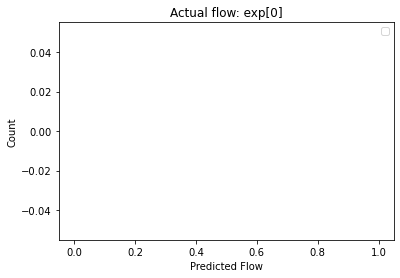

R:  nan %  R^2:  nan %


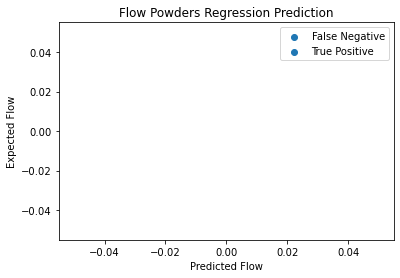

R:  nan %  R^2:  nan %


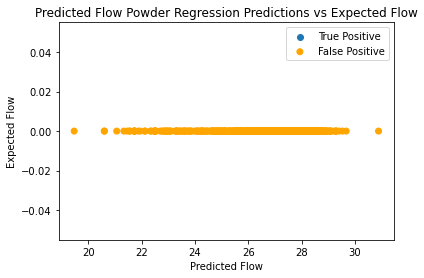

R:  nan %  R^2:  nan %


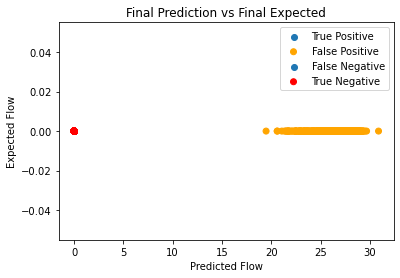

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  77.30471498944405 %	Actual Negative:  100.0 %
Positive Predicitons:  22.695285010555946 %	Actual Positive:  0.0 %

True Negatives:  2197 	 77.30471498944405 %
False Negatives:  0    0.0 %
False Positives:  645 	 22.695285010555946 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2197    77.30471498944405 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


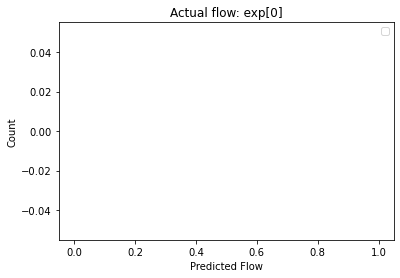

R:  nan %  R^2:  nan %


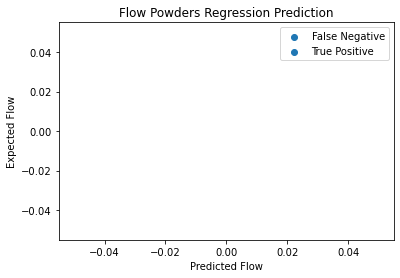

R:  nan %  R^2:  nan %


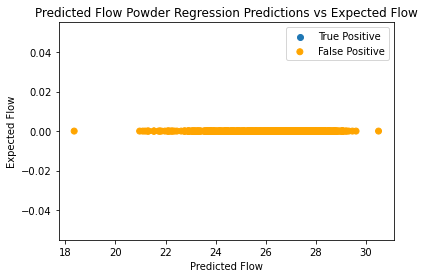

R:  nan %  R^2:  nan %


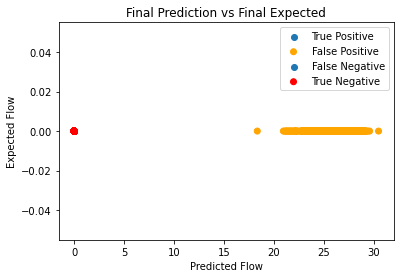

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  69.7396199859254 %	Actual Negative:  100.0 %
Positive Predicitons:  30.260380014074595 %	Actual Positive:  0.0 %

True Negatives:  1982 	 69.7396199859254 %
False Negatives:  0    0.0 %
False Positives:  860 	 30.260380014074595 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1982    69.7396199859254 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


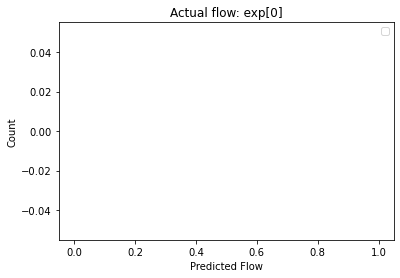

R:  nan %  R^2:  nan %


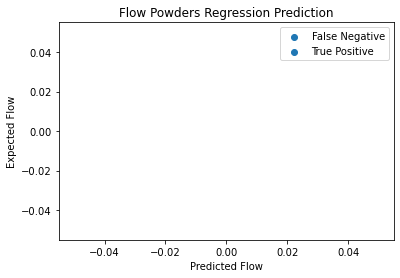

R:  nan %  R^2:  nan %


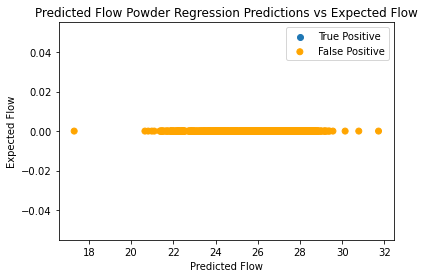

R:  nan %  R^2:  nan %


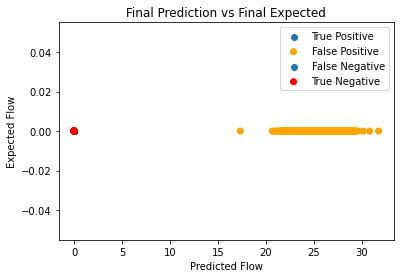

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  50.10555946516537 %	Actual Negative:  0.0 %
Positive Predicitons:  49.89444053483462 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1424    50.10555946516537 %
False Positives:  0 	 0.0 %
True Positives:  1418 	 49.89444053483462 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1418    49.89444053483462 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


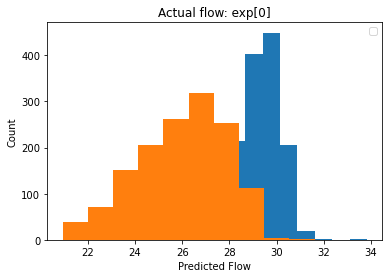

R:  nan %  R^2:  nan %


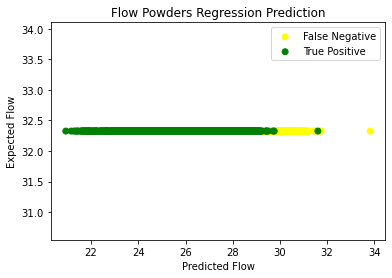

R:  nan %  R^2:  nan %


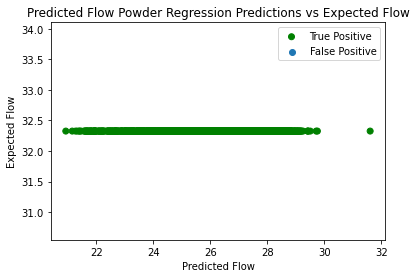

R:  0.0 %  R^2:  0.0 %


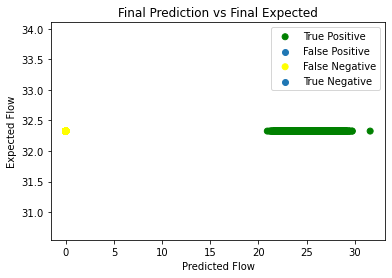

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  65.69317382125264 %	Actual Negative:  100.0 %
Positive Predicitons:  34.306826178747365 %	Actual Positive:  0.0 %

True Negatives:  1867 	 65.69317382125264 %
False Negatives:  0    0.0 %
False Positives:  975 	 34.306826178747365 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 1867    65.69317382125264 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


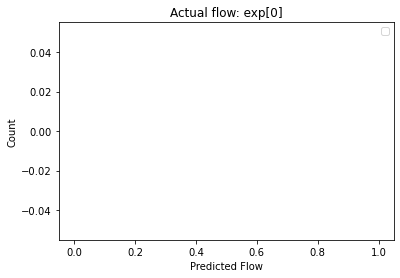

R:  nan %  R^2:  nan %


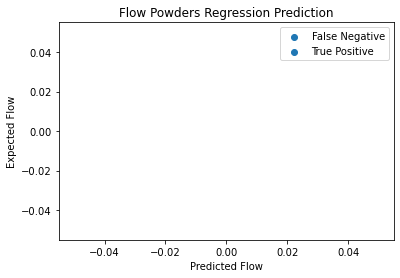

R:  nan %  R^2:  nan %


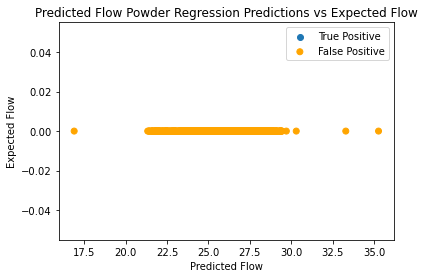

R:  nan %  R^2:  nan %


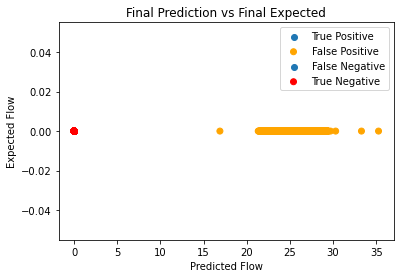

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  61.68191414496833 %	Actual Negative:  0.0 %
Positive Predicitons:  38.31808585503167 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1753    61.68191414496833 %
False Positives:  0 	 0.0 %
True Positives:  1089 	 38.31808585503167 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1089    38.31808585503167 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


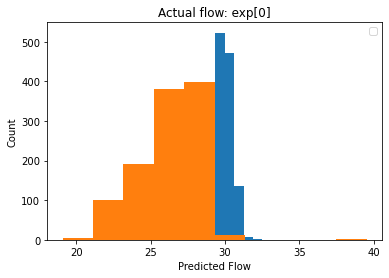

R:  nan %  R^2:  nan %


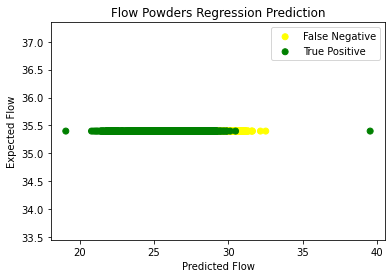

R:  nan %  R^2:  nan %


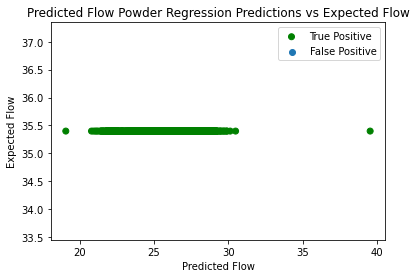

R:  nan %  R^2:  nan %


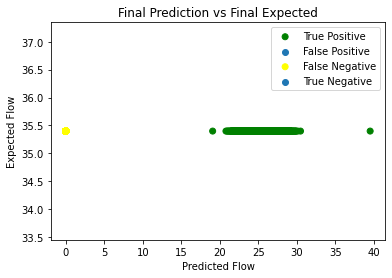

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  37.93103448275862 %	Actual Negative:  0.0 %
Positive Predicitons:  62.06896551724138 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1078    37.93103448275862 %
False Positives:  0 	 0.0 %
True Positives:  1764 	 62.06896551724138 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1764    62.06896551724138 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


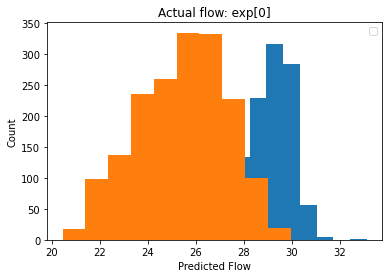

R:  0.0 %  R^2:  0.0 %


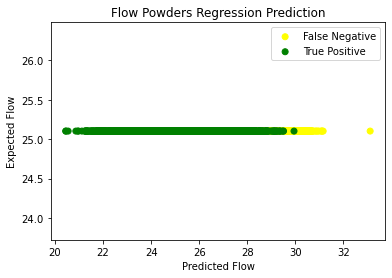

R:  0.0 %  R^2:  0.0 %


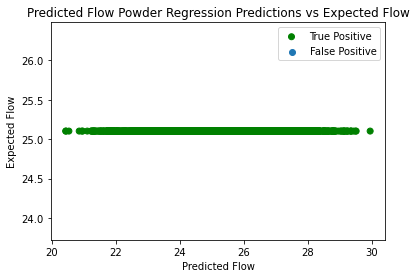

R:  nan %  R^2:  nan %


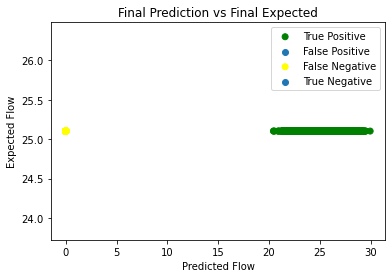

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  75.8972554539057 %	Actual Negative:  100.0 %
Positive Predicitons:  24.1027445460943 %	Actual Positive:  0.0 %

True Negatives:  2157 	 75.8972554539057 %
False Negatives:  0    0.0 %
False Positives:  685 	 24.1027445460943 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2157    75.8972554539057 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


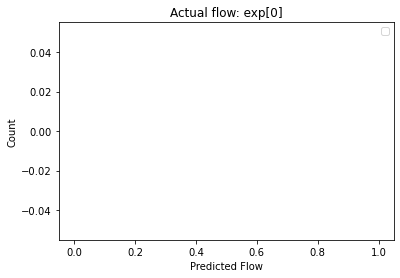

R:  nan %  R^2:  nan %


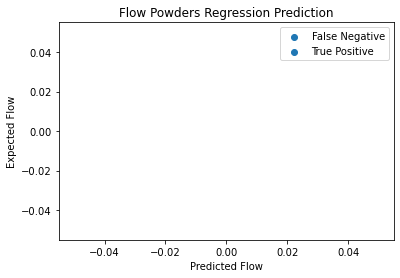

R:  nan %  R^2:  nan %


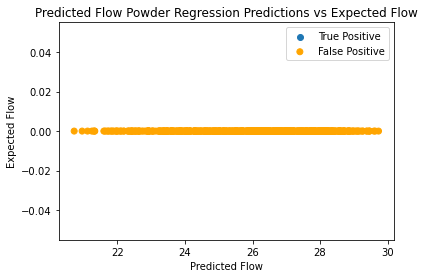

R:  nan %  R^2:  nan %


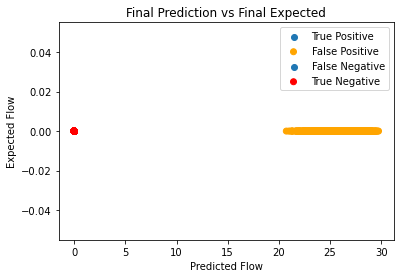

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  56.01688951442646 %	Actual Negative:  0.0 %
Positive Predicitons:  43.98311048557354 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1592    56.01688951442646 %
False Positives:  0 	 0.0 %
True Positives:  1250 	 43.98311048557354 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1250    43.98311048557354 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


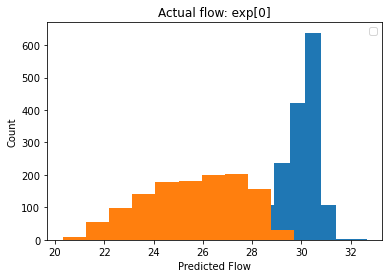

R:  nan %  R^2:  nan %


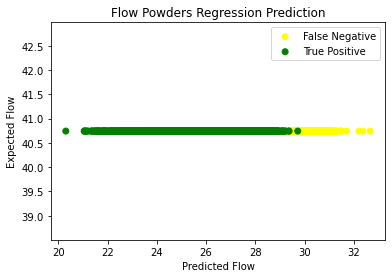

R:  nan %  R^2:  nan %


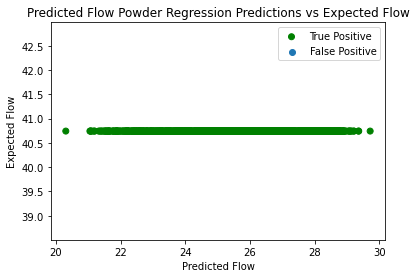

R:  -0.0 %  R^2:  0.0 %


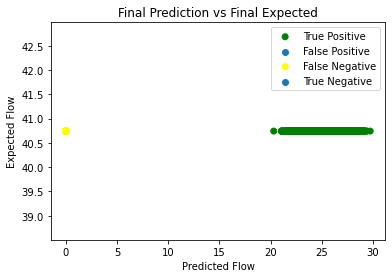

R:  nan %  R^2:  nan %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  41.41449683321605 %	Actual Negative:  0.0 %
Positive Predicitons:  58.58550316678396 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  1177    41.41449683321605 %
False Positives:  0 	 0.0 %
True Positives:  1665 	 58.58550316678396 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 1665    58.58550316678396 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


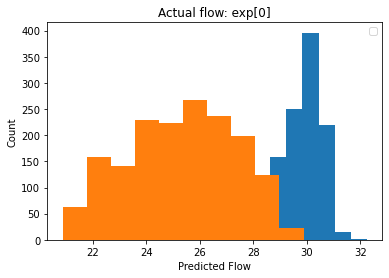

R:  0.0 %  R^2:  0.0 %


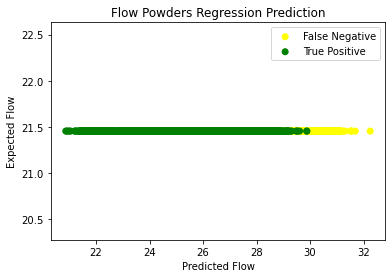

R:  0.0 %  R^2:  0.0 %


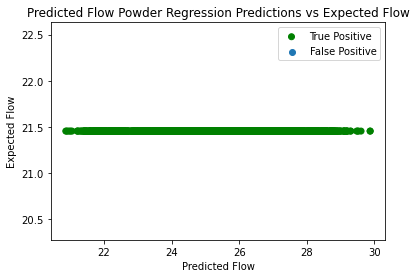

R:  -0.0 %  R^2:  0.0 %


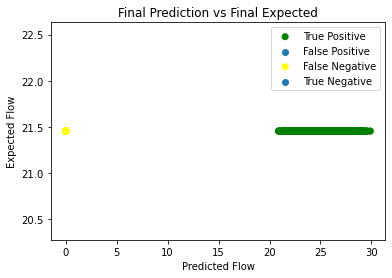

R:  0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
No handles with labels found to put in legend.


Classify results:

Negative Predictions:  28.95847994370162 %	Actual Negative:  0.0 %
Positive Predicitons:  71.04152005629838 %	Actual Positive:  100.0 %

True Negatives:  0 	 0.0 %
False Negatives:  823    28.95847994370162 %
False Positives:  0 	 0.0 %
True Positives:  2019 	 71.04152005629838 %

No Flow Predicitons:  0.0 % Correct
Flow Predictions:  100.0 % Correct

Correct Predictions: 2019    71.04152005629838 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


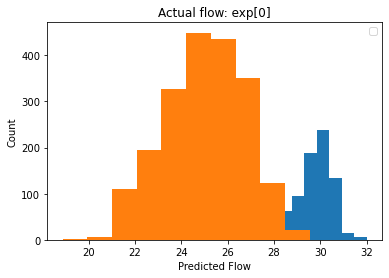

R:  0.0 %  R^2:  0.0 %


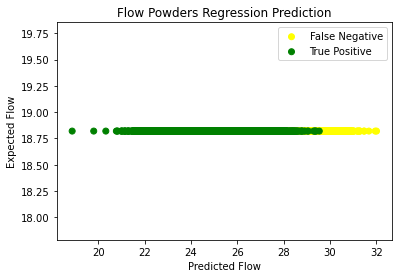

R:  0.0 %  R^2:  0.0 %


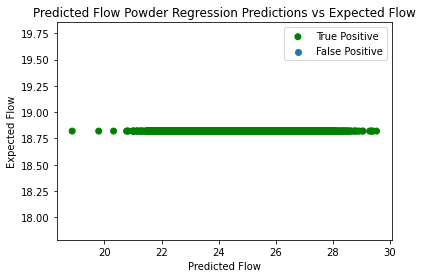

R:  -0.0 %  R^2:  0.0 %


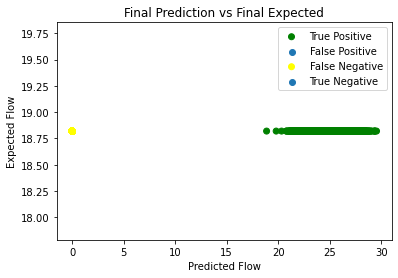

R:  -0.0 %  R^2:  0.0 %


C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\eadel\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493:

Classify results:

Negative Predictions:  82.6530612244898 %	Actual Negative:  100.0 %
Positive Predicitons:  17.346938775510203 %	Actual Positive:  0.0 %

True Negatives:  2349 	 82.6530612244898 %
False Negatives:  0    0.0 %
False Positives:  493 	 17.346938775510203 %
True Positives:  0 	 0.0 %

No Flow Predicitons:  100.0 % Correct
Flow Predictions:  0.0 % Correct

Correct Predictions: 2349    82.6530612244898 %
R:  nan %  R^2:  nan %


Regression Visualization and Statistics: 


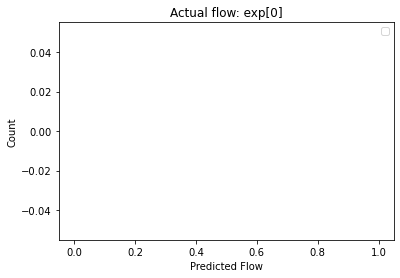

R:  nan %  R^2:  nan %


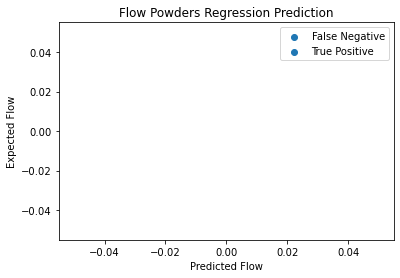

R:  nan %  R^2:  nan %


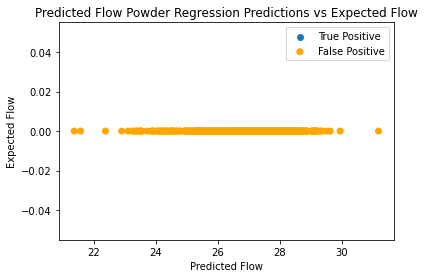

R:  nan %  R^2:  nan %


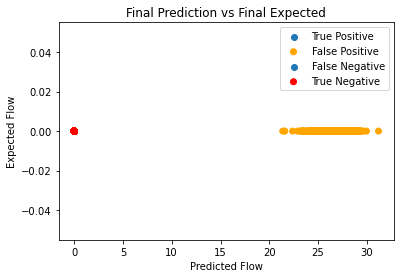

R:  nan %  R^2:  nan %


[]

In [16]:
results = []
cmodel
rmodel
for i in range(5):
    plist = []
    for i in datalist:
        plist.append(i.sample(n=2842))
    df = pd.concat(plist)
    df = df.sample(frac=1)
    flowdf = df[df["Flow Class"] == 1]
    cmodel = makemodel(df.drop(columns="Flow"), "Flow Class")
    rmodel = makemodel(flowdf.drop(columns="Flow Class"))
    for i in plist:
        modeltesthist(cmodel, rmodel, i)
results